In [8]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
# plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin"
# plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\fredr\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\pilot_runs\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\dev_runs\\"
target_dir = "C:\\Users\\fredr\\Documents\\quail_volcano\\scenarios\\verification_acoustic\\"

# Path for Quail source code
# source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"
source_dir = "C:\\Users\\fredr\\Documents\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [9]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%capture
%run $quail_path $target_file

In [5]:
import numpy as np
def size_tester(x):
  print(x.shape)
  return np.sin(x)


import scipy.integrate
scipy.integrate.quadrature(size_tester,
  0, 1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
idx = 140
cherrypick = f"C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\mixture_shocktube_conduit_{idx}.pkl"
solver = readwritedatafiles.read_data_file(cherrypick)
U = solver.state_coeffs

In [17]:
U_test = U[0:1,0:1,:]

In [60]:
import physics.multiphasevpT.atomics as atomics
tup = atomics.velocity_RI_fixed_p_quadrature(np.array(1e5), U_test, solver.physics)
tup[0].shape

c:\Python39\lib\site-packages\scipy\integrate\_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.909222e-01
  warnings.warn(


()

In [480]:
idx = 140
cherrypick = f"C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\mixture_shocktube_conduit_{idx}.pkl"
solver = readwritedatafiles.read_data_file(cherrypick)
plt.clf()
# plt.semilogy(solver.physics.compute_variable("Pressure", solver.state_coeffs).ravel() - 1e5)
plt.plot(solver.physics.compute_variable("Pressure", solver.state_coeffs).ravel() - 1e5)
plt.ylim([-1e5, 10e5])
# plt.plot((solver.physics.compute_variable("XVelocity", solver.state_coeffs).ravel() / 
              # solver.physics.compute_variable("SoundSpeed", solver.state_coeffs).ravel()))
plt.grid()

In [532]:
idx = 350
cherrypick = f"C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\mixture_shocktube_atm2_{idx}.pkl"
solver = readwritedatafiles.read_data_file(cherrypick)
# solver.physics.compute_variable("Pressure", solver.state_coeffs)

plt.clf()
# mdtools.viz(solver)
plot.get_numerical_solution(solver.physics, solver.state_coeffs, (500, 500),
					solver.basis, "Pressure")
x, q = mdtools.downsample(solver)
# mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
mdtools.plot_mean(x, q, (0, 1e7))

r45 = np.deg2rad(45)
r30 = np.deg2rad(30)
xloc45 = (200*np.cos(r45), 200*np.sin(r45))
xloc30 = (200*np.cos(r30), 200*np.sin(r30))
ploc45 = []
ploc30 = []
tseries = []
for idx in range(500):
	cherrypick = f"C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\mixture_shocktube_atm2_{idx}.pkl"
	solver = readwritedatafiles.read_data_file(cherrypick)

	temp, solver.order = solver.order, 0
	sample_pts = plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis, True)
	ppp = plot.get_numerical_solution(solver.physics, solver.state_coeffs,
			sample_pts, solver.basis, "Pressure")
	pp = plot.interpolate_2D_soln_to_points(solver.physics, 
		sample_pts, ppp, np.expand_dims(np.array(xloc45),axis=0))
	solver.order = temp
	ploc45.append(pp[0])

	temp, solver.order = solver.order, 0
	sample_pts = plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis, True)
	ppp = plot.get_numerical_solution(solver.physics, solver.state_coeffs,
			sample_pts, solver.basis, "Pressure")
	pp = plot.interpolate_2D_soln_to_points(solver.physics, 
		sample_pts, ppp, np.expand_dims(np.array(xloc30),axis=0))
	solver.order = temp
	ploc30.append(pp[0])

	tseries.append(solver.time)


In [536]:
plt.clf()
plt.plot(ploc30)
plt.plot(ploc45)

199432.522369179

In [14]:
%matplotlib tk
solver = readwritedatafiles.read_data_file(f"v0_pboundary_0.pkl")
physics = solver.physics
# Synthetic state
y1 = 0.0
y2 = 0.01#0.6
y3 = 0.99#0.4
y1, y2, y3 = (3.991878921524519e-05, 0.003467346031238321, 0.9964927351795464)

rho = 0.99*2500#2000
rho = 2505.086000000000
T = 1000
e = y1 * rho * physics.Gas[0]["c_v"] * T \
    + y2 * rho * physics.Gas[1]["c_v"] * T \
    + y3 * rho * (physics.Liquid["c_m"] * T + physics.Liquid["E_m0"])
U_L = np.array([y1*rho, y2*rho, y3*rho, 0, e, 0, 0])
U_L = np.expand_dims(U_L,axis=(0,1))

def mass_spec_entropy_gas(T, p, Gas):
  c_p = Gas["c_p"]
  gamma = Gas["gamma"]
  return c_p * np.log(T / p**((gamma-1.0)/gamma))

def mass_spec_entropy_mixture(U, T, p, physics):
  return (
    U[:,:,0] * mass_spec_entropy_gas(T, p, physics.Gas[0])[:,:,0]
    + U[:,:,1] * mass_spec_entropy_gas(T, p, physics.Gas[1])[:,:,0]
    + U[:,:,2] * physics.Liquid["c_m"] * np.log(T)[:,:,0]
    ) / U[:,:,0:3].sum(axis=2)

p1 = physics.compute_variable("Pressure", U_L)
T1 = physics.compute_variable("Temperature", U_L)
J1 = 0 + physics.compute_variable("SoundSpeed", U_L) / physics.compute_variable("beta", U_L)
S1 = mass_spec_entropy_mixture(U_L, T1, p1, physics)

In [40]:
''' Root solve for p, for u-c >= (u-c)_L, constrained by 4 knowns
    1. y1
    2. y2 (and y3)
    3. J1
    4. S1
and for simplicity removing the tracer states
    5. 0
    6. 0
'''
from scipy.optimize import fsolve


def mass_spec_entropy_gas(T, p, Gas):
  c_p = Gas["c_p"]
  gamma = Gas["gamma"]
  return c_p * np.log(T / p**((gamma-1.0)/gamma))

def mass_spec_entropy_mixture(U, T, p, physics):
  return (
    U[:,:,0] * mass_spec_entropy_gas(T, p, physics.Gas[0])[:,:,0]
    + U[:,:,1] * mass_spec_entropy_gas(T, p, physics.Gas[1])[:,:,0]
    + U[:,:,2] * physics.Liquid["c_m"] * np.log(T)[:,:,0]
    ) / U[:,:,0:3].sum(axis=2)

def update_U(U, U_L, y1, y2, y3, drho, physics):
# if True:
    # use U as the previous step, and U_L for computing the invariants to prevent accumulation of error
    U_out = U.copy()
    # Mass fraction constraints
    U_out[:,:,0:3] += np.array([y1, y2, y3]) * drho

    # Define entropy and J1 (acoustic-related Riemann invariant) constraints
    def compute_S(U):
        p = (physics.compute_variable("Pressure", U))
        # print(p)
        # if p < 0:
            # print(U)
        return mass_spec_entropy_mixture(U,
            physics.compute_variable("Temperature", U),
            physics.compute_variable("Pressure", U),
            physics)
    def compute_J1(U):
        return (U[:,:,3] / U[:,:,0:3].sum(axis=2) +
            physics.compute_variable("SoundSpeed", U) 
            / physics.compute_variable("beta", U))
    target_S = compute_S(U_L)
    target_J1 = compute_J1(U_L)

    # Define the residual equation for S = S_fixed, J1 = J1_fixed
    def residual_eqn(v):
        rhou, e = v
        U = U_out.copy()
        U[:,:,3:4] = rhou
        U[:,:,4:5] = e
        eqn_1 = ((compute_S(U) - target_S)/target_S).squeeze()
        # eqn_2 = ((compute_J1(U) - target_J1)/target_J1).squeeze()
        w = (U_out[:,:,3:4] / U_out[:,:,0:3].sum(axis=2,keepdims=True) - \
            physics.compute_variable("SoundSpeed", U)).squeeze()
        eqn_2 = (rhou - U_out[:,:,3].squeeze() - w*drho)
        return (eqn_1, eqn_2)

    # Compute invariant-constrained state
    rhou, e = fsolve(residual_eqn, (U_out[:,:,3].squeeze(), U_out[:,:,4].squeeze()))
    U_out[:,:,3:4] = rhou
    U_out[:,:,4:5] = e
    return U_out

# update_U(U, U_L, y1, y2, y3, drho, physics)

In [65]:
# Num explore steps
N_steps = 2500*2

# Allocate history containers
U_all_shape = tuple([N_steps+1, *list(U_L.shape)])
U_all = np.zeros(U_all_shape)
S_all = np.zeros((N_steps+1,))
J1_all = np.zeros((N_steps+1,))
p_all = np.zeros((N_steps+1,))
u_all = np.zeros((N_steps+1,))
rho_all = np.zeros((N_steps+1,))
a_all = np.zeros((N_steps+1,))
w_all = np.zeros((N_steps+1,))
dyn_all = np.zeros((N_steps+1,))

drho = -1.0/2
U = U_L.copy()

for i in range(N_steps+1):
    U_all[i,:,:,:] = U
    S_all[i] = mass_spec_entropy_mixture(U,
            physics.compute_variable("Temperature", U),
            physics.compute_variable("Pressure", U),
            physics).squeeze()
    rho_all[i] = U[:,:,0:3].sum(axis=2).squeeze()
    u_all[i] = (U[:,:,3] / U[:,:,0:3].sum(axis=2)).squeeze()
    a_all[i] = physics.compute_variable("SoundSpeed", U).squeeze()
    J1_all[i] = (U[:,:,3] / U[:,:,0:3].sum(axis=2) + 
            physics.compute_variable("SoundSpeed", U) 
            / physics.compute_variable("beta", U)).squeeze()
    p_all[i] = physics.compute_variable("Pressure", U)
    w_all[i] = u_all[i] - a_all[i]

    F, _, = physics.get_conv_flux_interior(U)
    F = F.squeeze()
    l = physics.get_eigenvectors_L(U)[:,:,3,:].squeeze()
    r = physics.get_eigenvectors_R(U)[:,:,:,3].squeeze()

    dyn_all[i] = np.dot(l, F)

    U = update_U(U, U_L, y1, y2, y3, drho, physics)
    


In [67]:
# Compute expansion fan at t = 1
# Extension of w_all * (t = 1) = w_all
x_ext = w_all.copy()
x_ext = np.array([-2000, *x_ext])
extend = lambda v: np.array([v[0], *v])
plt.figure(10)
plt.clf()
plt.plot(x_ext, extend(a_all), '.-')

In [432]:
%load_ext autoreload
%autoreload 2
import physics.multiphasevpT.utils
replacement_solver = readwritedatafiles.read_data_file(f"v0_pboundary_0.pkl")
RS = physics.multiphasevpT.utils.RiemannSolution(replacement_solver.physics)

xi, U = RS.compute_solution(U_L)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [437]:
plt.figure()
plt.plot(xi,U[:,:,:,5].squeeze(), '.-')

In [50]:
plt.figure(1)
plt.clf()

plot_quants = (rho_all, p_all, u_all, a_all, S_all-S_all[0], J1_all-J1_all[0],
    w_all)
plot_labels = ["rho", "p", "u", "a", "$\Delta S$", "$u + a / \\beta$",
    "u-a"]

for i in range(7):
    plt.subplot(3,3,i+1)
    plt.plot(w_all, plot_quants[i])
    plt.plot(w_all[0], plot_quants[i][0], '.')
    plt.xlabel("(u-a)")
    plt.ylabel(plot_labels[i])

plt.figure(2)
plt.clf()
plt.plot(rho_all, w_all)
plt.plot(rho_all[0], w_all[0], '.')
plt.xlabel("$\\rho$")
plt.ylabel("u - a")

plt.show()

In [89]:
plt.figure(3)
plt.clf()
plt.subplot(1,3,1)
plt.plot(rho_all, -dyn_all)
plt.subplot(1,3,2)
plt.plot(rho_all[1:], (-dyn_all[1:] + dyn_all[0:-1])/(rho_all[1:] - rho_all[0:-1]))
plt.subplot(1,3,3)
plt.plot(rho_all, w_all)

In [91]:
plt.figure(4)
plt.clf()

idx = 50
solver = readwritedatafiles.read_data_file(f"C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\p2_4s_refine3\\mixture_shocktube_conduit_{idx}.pkl")
# plt.plot(solver.state_coeffs[:,:,0].squeeze())
# plt.plot(solver.physics.compute_variable("Pressure", solver.state_coeffs).squeeze())

x_mesh = 0.5*(solver.mesh.node_coords[1:,:] 
  + solver.mesh.node_coords[:-1,:])
print(f"t = {solver.time} s")

plt.subplot(3,3,1)
plt.plot(x_mesh, solver.state_coeffs[:,:,0:3].sum(axis=2).squeeze())
plt.plot(solver.time*x_ext, extend(rho_all), '.-')

plt.subplot(3,3,2)
plt.plot(x_mesh, solver.state_coeffs[:,:,0].squeeze())
plt.plot(solver.time*x_ext, extend(U_all[:,:,:,0].squeeze()), '.-')

plt.subplot(3,3,3)
plt.plot(x_mesh, solver.state_coeffs[:,:,1].squeeze())
plt.plot(solver.time*x_ext, extend(U_all[:,:,:,1].squeeze()), '.-')

plt.subplot(3,3,4)
plt.plot(x_mesh, solver.state_coeffs[:,:,2].squeeze())
plt.plot(solver.time*x_ext, extend(U_all[:,:,:,2].squeeze()), '.-')

plt.subplot(3,3,5)
plt.plot(x_mesh, solver.state_coeffs[:,:,3].squeeze())
plt.plot(solver.time*x_ext, extend(U_all[:,:,:,3].squeeze()), '.-')

plt.subplot(3,3,6)
u_mesh = (solver.state_coeffs[:,:,3] / solver.state_coeffs[:,:,0:3].sum(axis=2)).squeeze()
plt.plot(x_mesh, u_mesh)
plt.plot(solver.time*x_ext, extend(u_all), '.-')

# plt.subplot(3,3,7)
# p_mesh = solver.physics.compute_variable("Pressure", solver.state_coeffs).squeeze()
# plt.plot(x_mesh, p_mesh)
# plt.plot(solver.time*x_ext, extend(p_mesh), '.-')

t = 0.20000000000012963 s


In [148]:
# Search energy, pressure
e = U_all[:,:,:,4].squeeze()
e_int_all = e - 0.5*rho_all*u_all**2
rho_R = solver.state_coeffs[-1:,-1:,0:3].sum(axis=2).squeeze()
e_int_R = solver.state_coeffs[:,:,4] - 0.5*solver.state_coeffs[:,:,3]**2 / \
  solver.state_coeffs[:,:,0:3].sum(axis=2)
e_int_R = e_int_R[-1:,-1:].squeeze()
p_R = 1e5
RH = lambda rho, e_int, p :\
  (rho_R * e_int - rho * e_int_R) / (rho - rho_R) -  0.5*(p + p_R)

plt.figure(5)
plt.clf()
plt.plot(RH(rho_all, e_int_all, p_all))

In [210]:
# Getting post-shock values
rho_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), rho_all)
u_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), u_all)
p_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), p_all)
# Capping
ind = np.interp(0, RH(rho_all, e_int_all, p_all), range(len(RH(rho_all, e_int_all, p_all))))
clipped_fan = lambda v: np.array([*v[0:int(ind)+1], 
  np.interp(0, RH(rho_all, e_int_all, p_all), v)])
plt.figure(5)
plt.clf()
plt.plot(clipped_fan(w_all), clipped_fan(u_all), '.')
# clipped_fan(w_all).shape
# np.interp(0, RH(rho_all, e_int_all, p_all), u_all)
# u_all[0:int(ind)+1][-1]

plt.subplot(3,3,1)
plt.plot(x_mesh, solver.state_coeffs[:,:,0:3].sum(axis=2).squeeze())
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(rho_all)), '.-')

plt.subplot(3,3,2)
plt.plot(x_mesh, solver.state_coeffs[:,:,0].squeeze())
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,0].squeeze())), '.-')

plt.subplot(3,3,3)
plt.plot(x_mesh, solver.state_coeffs[:,:,1].squeeze())
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,1].squeeze())), '.-')

plt.subplot(3,3,4)
plt.plot(x_mesh, solver.state_coeffs[:,:,2].squeeze())
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,2].squeeze())), '.-')

plt.subplot(3,3,5)
plt.plot(x_mesh, solver.state_coeffs[:,:,3].squeeze())
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,3].squeeze())), '.-')

plt.subplot(3,3,6)
u_mesh = (solver.state_coeffs[:,:,3] / solver.state_coeffs[:,:,0:3].sum(axis=2)).squeeze()
plt.plot(x_mesh, u_mesh)
plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(u_all)), '.-')


In [156]:
# Adding in shock
shock_speed = u_post_shock + (p_post_shock - p_R) / (rho_post_shock * u_post_shock)
# extend_R = lambda v: np.array([*v[0:int(ind)+1], 
  # np.interp(0, RH(rho_all, e_int_all, p_all), v)])
# shock_speed * (rho_post_shock - rho_R) - rho_post_shock * u_post_shock
rho_post_shock

1536.7203343482313

In [266]:
''' Solving Rankine-Hugoniot + contact condition
There may not be a solution to this!?
'''
# Fan coord -> state
u_mapping = lambda xi: np.interp(xi, w_all, u_all)
p_mapping = lambda xi: np.interp(xi, w_all, p_all)

# Temperature mapping
def e_int(yA, yWv, yM, p, rho):
  # Compute temperature-independent vars
  rho_m = physics.Liquid["rho0"] * (1.0 + 1.0/physics.Liquid["K"] *
    (p - physics.Liquid["p0"]))
  alpha_m = yM * rho / rho_m
  alpha_g = 1.0 - alpha_m
  # Compute temperature from temperature-dependent vars
  T = (p * alpha_g) / (rho*(yA*physics.Gas[0]["R"] + yWv*physics.Gas[1]["R"]))
  alpha_A = rho*yA / p * physics.Gas[0]["R"] * T
  alpha_Wv = rho*yWv / p * physics.Gas[1]["R"] * T
  # Compute internal energy density
  e_int = rho * (yA * physics.Gas[0]["c_v"] * T
    + yWv * physics.Gas[1]["c_v"] * T 
    + yM * (physics.Liquid["c_m"] * T + physics.Liquid["E_m0"])
  )
  return e_int

U_R = solver.state_coeffs[-1,-1,:]
rho_R = solver.state_coeffs[-1:,-1:,0:3].sum(axis=2).squeeze()
yA_R = solver.state_coeffs[-1,-1,0] / rho_R
yWv_R = solver.state_coeffs[-1,-1,1] / rho_R
yM_R = solver.state_coeffs[-1,-1,2] / rho_R

e_int_mapping = lambda xi, rho: e_int(yA_R, yWv_R, yM_R, p_mapping(xi), rho)

# Define the residual equation for S = S_fixed, J1 = J1_fixed
def residual_eqn_contact(v):
    xi, rho = v
    eqn_1 = (rho_R / (rho - rho_R) * e_int_mapping(xi, rho) - \
      rho / (rho - rho_R) * e_int_R - 0.5*(p_mapping(xi) + p_R)) / p_R
    eqn_2 = (rho * u_mapping(xi)**2.0 * rho_R / (rho - rho_R) 
      - p_mapping(xi) + p_R) / p_R
    # print(e_int_mapping(xi, rho))
    # print(eqn_1, eqn_2)
    return (eqn_1, eqn_2)

# Compute invariant-constrained state
xi, rho = fsolve(residual_eqn_contact, (-100, 1.2))

# On success, compute post-contact state
u_contact = u_mapping(xi)
p_contact = p_mapping(xi)
U_contact_ess = np.array([rho*yA_R, rho*yWv_R, rho*yM_R, rho*u_contact, 
  e_int(yA_R, yWv_R, yM_R, p_contact, rho) + 0.5*rho*u_contact**2.0])

shock_speed = rho * u_contact / (rho - rho_R)

In [255]:
fan_x = fan_contact_x(w_all, xi)
# U_all[:,:,:,0].squeeze().shape
fan_q1 = np.array([
  *clipped_fan2(U_all[:,:,:,0].squeeze(), xi), clipped_fan2(U_all[:,:,:,0].squeeze(), xi)[-1],
  U_contact_ess[0], U_contact_ess[0]])
plt.figure()
plt.plot(fan_q1)

In [411]:
U_path = U_L.copy()
# curve_path = 
U_path.shape

def wave_speed(U):
  return U[:,:,3]/U[:,:,0:3].sum(axis=2) - \
    physics.compute_variable("SoundSpeed", U)

def path_vec(U_path):
  curve_path = np.zeros_like(U_path)
  curve_path[:,:,0:3] = U_path[:,:,0:3]/U_path[:,:,0:3].sum(axis=2, keepdims=True)
  curve_path[:,:,5:7] = U_path[:,:,5:7]/U_path[:,:,0:3].sum(axis=2, keepdims=True)
  curve_path[:,:,3] = wave_speed(U_path)
  return curve_path

def mass_spec_entropy_mixture(U, T, p, physics):
  return (
    U[:,:,0] * mass_spec_entropy_gas(T, p, physics.Gas[0])[:,:,0]
    + U[:,:,1] * mass_spec_entropy_gas(T, p, physics.Gas[1])[:,:,0]
    + U[:,:,2] * physics.Liquid["c_m"] * np.log(T)[:,:,0]
    ) / U[:,:,0:3].sum(axis=2)

def step(U, drho, U_origin=None):
  if U_origin is None:
    U_origin = U
  ''' Step along integral curve '''
  # Butcher table for Cash-Karp RK quadrature
  B = np.array([[1/5, 0, 0, 0, 0],
        [3/40, 9/40, 0, 0, 0],
        [3/10, -9/10, 6/5, 0, 0],
        [-11/54, 5/2, -70/27, 35/27, 0],
        [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]])
  w = np.array([37/378, 0, 250/621, 125/594 , 0, 512/1771])
  num_stages = w.shape[0]
  k = np.zeros((num_stages, *U.shape,))
  k[0,:,:,:] = path_vec(U)
  for j in range(B.shape[0]):
      k[j+1,:,:,:]= path_vec(U + drho*
          np.einsum("m, mijk -> ijk", B[j,0:j+1], k[0:j+1,:]))
  dU = drho * np.einsum("i, ijkl -> jkl", w, k)

  ''' Compute energy as dependent variable from entropy condition '''
  compute_S = lambda U : mass_spec_entropy_mixture(U,
    physics.compute_variable("Temperature", U),
    physics.compute_variable("Pressure", U),
    physics).squeeze()
  # Unit vector for energy
  e_unitvec = np.zeros_like(U)
  e_unitvec[:,:,4:5] = 1.0
  de = fsolve(lambda de: compute_S(U + dU + de*e_unitvec)/compute_S(U_origin) - 1.0, 0)
  # print(compute_S(U + dU + de*e_unitvec))
  return U + dU + de*e_unitvec


data_triplets = []
U = U_L.copy()
rho = U[0,0,0:3].sum()
delta_rho = -2
ind_max = int(rho/np.abs(delta_rho))
for i in range(ind_max):
  U = step(U, delta_rho, U_origin=U_L)
  rho += delta_rho
  data_triplets.append((wave_speed(U).squeeze(), rho, U.copy(),))

In [420]:
plt.figure(11)
plt.clf()
plt.plot(
  np.array(list(zip(*data_triplets))[0]),
  np.array(list(zip(*data_triplets))[2])[:,0,0,0],
  '.-'
)

In [326]:
# rho_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), rho_all)
# u_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), u_all)
# p_post_shock = np.interp(0, RH(rho_all, e_int_all, p_all), p_all)
# Capping
ind_fn = lambda xi : np.interp(0, w_all - xi, range(len(w_all)))
# Parametrizing the expansion+contact as a function of xi
clipped_fan2 = lambda v, xi: np.array([*v[0:int(ind_fn(xi))+1],
  np.interp(0, w_all - xi, v)])
fan_contact_x = lambda v, xi: np.array([
  *clipped_fan2(v, xi), np.interp(xi, w_all, u_all) - 1e-10,
  np.interp(xi, w_all, u_all) + 1e-10, shock_speed - 1e-10,
  shock_speed + 1e-10, shock_speed + 600])
# fan_contact = lambda v, xi: np.array([
#   *clipped_fan2(v, xi), clipped_fan2(v, xi)[-1],
#   1.1*clipped_fan2(v, xi)[-1], 1.1*clipped_fan2(v, xi)[-1]])
plt.figure(7)
plt.clf()

fan_x = fan_contact_x(w_all, xi)
fan_q = [1,2,3,4,5]
for i in range(5):
  fan_q[i] = np.array([
    *clipped_fan2(U_all[:,:,:,i].squeeze(), xi), clipped_fan2(U_all[:,:,:,i].squeeze(), xi)[-1],
    U_contact_ess[i], U_contact_ess[i],
    U_R[i], U_R[i]])

xi_fit = 210

plt.subplot(3,3,1)
plt.plot(x_mesh, solver.state_coeffs[:,:,0:3].sum(axis=2).squeeze())
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(rho_all)), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(rho_all, xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[0]+fan_q[1]+fan_q[2], '.-')
plt.xlabel("$x$")
plt.ylabel("$\\rho$")

plt.subplot(3,3,2)
plt.plot(x_mesh, solver.state_coeffs[:,:,0].squeeze())
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,0].squeeze())), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(U_all[:,:,:,0].squeeze(), xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[0], '.-')
plt.xlabel("$x$")
plt.ylabel("$\\alpha_a \\rho_a$")

plt.subplot(3,3,3)
plt.plot(x_mesh, solver.state_coeffs[:,:,1].squeeze())
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,1].squeeze())), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(U_all[:,:,:,1].squeeze(), xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[1], '.-')
plt.xlabel("$x$")
plt.ylabel("$\\alpha_{wv} \\rho_{wv}$")

plt.subplot(3,3,4)
plt.plot(x_mesh, solver.state_coeffs[:,:,2].squeeze())
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,2].squeeze())), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(U_all[:,:,:,2].squeeze(), xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[2], '.-')
plt.xlabel("$x$")
plt.ylabel("$\\alpha_m \\rho_m$")

plt.subplot(3,3,5)
plt.plot(x_mesh, solver.state_coeffs[:,:,3].squeeze())
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(U_all[:,:,:,3].squeeze())), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(U_all[:,:,:,3].squeeze(), xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[3], '.-')
plt.xlabel("$x$")
plt.ylabel("$\\rho u$")

plt.subplot(3,3,6)
u_mesh = (solver.state_coeffs[:,:,3] / solver.state_coeffs[:,:,0:3].sum(axis=2)).squeeze()
plt.plot(x_mesh, u_mesh)
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(u_all)), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(u_all, xi_fit), '.-')
plt.plot(solver.time*fan_x, fan_q[3] / (fan_q[0]+fan_q[1]+fan_q[2]), '.-')
plt.xlabel("$x$")
plt.ylabel("$u$")

S_numeric = mass_spec_entropy_mixture(
  solver.state_coeffs,
  solver_subs.physics.compute_variable("Temperature", solver.state_coeffs), 
  solver_subs.physics.compute_variable("Pressure", solver.state_coeffs),
  physics)

# Cast fan_q:list -> fan_U:np.array(shape=(ne,nb,ns))
fan_U = np.array([*fan_q, 0*fan_q[0], 0*fan_q[0]]).T
fan_U = np.expand_dims(fan_U, axis=1)
S_fan = mass_spec_entropy_mixture(
  fan_U,
  solver_subs.physics.compute_variable("Temperature", fan_U), 
  solver_subs.physics.compute_variable("Pressure", fan_U),
  physics)

plt.subplot(3,3,7)
plt.plot(x_mesh, S_numeric)
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(u_all)), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(u_all, xi_fit), '.-')
plt.plot(solver.time*fan_x, S_fan, '.-')
plt.xlabel("$x$")
plt.ylabel("$S$ (per mass)")

plt.subplot(3,3,8)
rhoS_fan = ((fan_q[0]+fan_q[1]+fan_q[2]).squeeze()*S_fan.squeeze())
diff_rhoS = solver.state_coeffs[:,:,0:3].sum(axis=2).squeeze() * S_numeric.squeeze() \
  - np.interp(x_mesh.squeeze(), solver.time*fan_x.squeeze(), rhoS_fan)
plt.plot(x_mesh.squeeze(), diff_rhoS)
# plt.plot(solver.time*extend(clipped_fan(w_all)), extend(clipped_fan(u_all)), '.-')
# plt.plot(solver.time*fan_contact_x(w_all, xi_fit), fan_contact(u_all, xi_fit), '.-')
# plt.plot(solver.time*fan_x, S_fan, '.-')
plt.xlabel("$x$")
plt.ylabel("$S_{num} - S_{ex}$ (per mass)")

dx = np.mean(x_mesh[1:] - x_mesh[:-1])
int_diff_rhoS = np.sum(diff_rhoS) * dx
print(f"Integral of rho Delta S = {int_diff_rhoS}")

Integral of rho Delta S = 57009869.82684495


In [325]:
# solver_subs = readwritedatafiles.read_data_file(f"v0_pboundary_146.pkl")
# solver_subs.physics.compute_variable("Pressure", solver.state_coeffs)

57009869.82684495

In [38]:
solver.state_coeffs[0,0,0]/solver.state_coeffs[0,0,0:3].sum(), \
  solver.state_coeffs[0,0,1]/solver.state_coeffs[0,0,0:3].sum(), \
  solver.state_coeffs[0,0,2]/solver.state_coeffs[0,0,0:3].sum()
solver.state_coeffs[0,0,0:3].sum()
def compute_S(U):
    p = (physics.compute_variable("Pressure", U))
    # print(p)
    # if p < 0:
        # print(U)
    return mass_spec_entropy_mixture(U,
        physics.compute_variable("Temperature", U),
        physics.compute_variable("Pressure", U),
        physics)
def compute_JTest(U):
    # return (U[:,:,3:4] / U[:,:,0:3].sum(axis=2, keepdims=True) +
    #     physics.compute_variable("SoundSpeed", U) 
    #     / physics.compute_variable("beta", U))
    return (U[:,:,3:4] / U[:,:,0:3].sum(axis=2, keepdims=True) +
        2 * physics.compute_variable("SoundSpeed", U) 
        / (physics.compute_variable("Gamma", U) - 1)
        / (physics.compute_variable("Psi1", U))
    )

plt.clf()
plt.subplot(3,1,1)
plt.plot(solver.state_coeffs[:,:,0:3].sum(axis=2).squeeze())
plt.subplot(3,1,2)
plt.plot(compute_S(solver.state_coeffs))
plt.subplot(3,1,3)
plt.plot(compute_JTest(solver.state_coeffs).squeeze())

In [3]:
%matplotlib tk
solver = readwritedatafiles.read_data_file(f"v0_pboundary_25.pkl")
mdtools.viz(solver, "Temperature")

: 

In [ ]:
# Testing Newton-RK p BC implementation
%matplotlib tk
solver = readwritedatafiles.read_data_file(f"v0_pboundary_25.pkl")
# Quick visualization
mdtools.viz(solver, "Temperature")
# Generate animation
mdtools.generate_anim([], ["v0_pboundary"], "v0_pboundary_test", 25,
  "Pressure", filter=lambda x, x0:np.log10(x), initial=1, stride=1, is_high_detail=False)

In [89]:
# Phi aniumation
%matplotlib tk
# Generate animation
mdtools.generate_anim(0*["v0_phi0800m_atm1", "v0_phi0800m_atm2", "v0_phi0800m_atm3"],
  ["v0_phi0800m_conduit1"],
  "0800phi", 74,
  "phi", initial=1, stride=5, is_high_detail=False)

Animation constructed


In [91]:
mdtools.viz(readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_250.pkl"), "SoundSpeed")

In [8]:
%matplotlib tk
# - 375
plt.figure(figsize=(11, 11), dpi=80)
run_code = "0600" # File set size 1200
mdtools.generate_anim(
  [f"v0_phi{run_code}m_atm1", f"v0_phi{run_code}m_atm2", f"v0_phi{run_code}m_atm3"],
  [f"v0_phi{run_code}m_conduit1", f"v0_phi{run_code}m_conduit2"], f"_output_v0phi{run_code}", 119,
  "Pressure", filter=lambda x, x0:np.log10(np.abs(x-x0)), initial=1, stride=10, is_high_detail=False)
# run_code = "0700" # File set size 375
# mdtools.generate_anim(
#   [f"v0_phi{run_code}m_atm1", f"v0_phi{run_code}m_atm2", f"v0_phi{run_code}m_atm3"],
#   [f"v0_phi{run_code}m_conduit1", f"v0_phi{run_code}m_conduit2"], f"_output_v0phi{run_code}", 74,
#   "Pressure", filter=lambda x, x0:np.log10(np.abs(x-x0)), initial=1, stride=5, is_high_detail=False)

Animation constructed


In [25]:
# Compute mass rate out at z = -150
data_set_size = 375 # Not including file0
plot_idx = 0
solver = readwritedatafiles.read_data_file(f"v0_phi0700m_conduit1_{plot_idx}.pkl")
# Generate mass flux array
rhou_times_radius0700 = np.tile(solver.state_coeffs[-1,:,3]*50,(data_set_size+1,1,1))
t0700 = np.tile(solver.time, (data_set_size+1))
for i in range(data_set_size):
  solver = readwritedatafiles.read_data_file(f"v0_phi0700m_conduit1_{i+1}.pkl")
  rhou_times_radius0700[i+1,:,:] = solver.state_coeffs[-1,:,3]*50
  t0700[i+1] = solver.time

data_set_size = 375 # Not including file0
plot_idx = 0
solver = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")
# Generate mass flux array
rhou_times_radius0800 = np.tile(solver.state_coeffs[-1,:,3]*50,(data_set_size+1,1,1))
t0800 = np.tile(solver.time, (data_set_size+1))
for i in range(data_set_size):
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{i+1}.pkl")
  rhou_times_radius0800[i+1,:,:] = solver.state_coeffs[-1,:,3]*50
  t0800[i+1] = solver.time

data_set_size = 1200 # Not including file0
plot_idx = 0
solver = readwritedatafiles.read_data_file(f"v0_phi0600m_conduit1_{plot_idx}.pkl")
# Generate mass flux array
rhou_times_radius0600 = np.tile(solver.state_coeffs[-1,:,3]*50,(data_set_size+1,1,1))
t0600 = np.tile(solver.time, (data_set_size+1))
for i in range(data_set_size):
  solver = readwritedatafiles.read_data_file(f"v0_phi0600m_conduit1_{i+1}.pkl")
  rhou_times_radius0600[i+1,:,:] = solver.state_coeffs[-1,:,3]*50
  t0600[i+1] = solver.time

In [27]:
plt.clf()
l0800, = plt.plot(t0800.squeeze(), rhou_times_radius0800.squeeze(), label="$\\phi_{cr} = 0.8$")
l0700, = plt.plot(t0700.squeeze(), rhou_times_radius0700.squeeze(), label="$\\phi_{cr} = 0.7$")
l0600, = plt.plot(t0600.squeeze(), rhou_times_radius0600.squeeze(), label="$\\phi_{cr} = 0.6$")
plt.xlabel("t (s)")
plt.ylabel("$\\rho u * R_{conduit}$")
plt.legend(handles=[l0800, l0700, l0600])

In [70]:
# Compute vorticity
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  du_ij = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        solver.state_coeffs[:,:,1:3]/solver.state_coeffs[:,:,0:1])
  vorticity = du_ij[:,:,1:2,0] - du_ij[:,:,0:1,1]
  x, _ = mdtools.downsample(solver)
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, np.log(np.abs(vorticity)), (-5,7))

clims = (-5,7)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("$log_{10} |\\omega|$")

In [ ]:
# Compute vorticity
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  du_ij = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        solver.state_coeffs[:,:,1:3]/solver.state_coeffs[:,:,0:1])
  vorticity = du_ij[:,:,1:2,0] - du_ij[:,:,0:1,1]
  x, _ = mdtools.downsample(solver)
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, np.log(np.abs(vorticity)), (-5,7))

clims = (-5,7)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("$log_{10} |\\omega|$")

In [102]:
# Compute sound speed
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  x, soundspeed = mdtools.downsample(solver, "SoundSpeed")
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, soundspeed, (0,500))

clims = (0,500)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("sound speed (m/s)")

In [106]:
# Compute pressure
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  x, soundspeed = mdtools.downsample(solver, "Pressure")
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, soundspeed, (0,5e5))

clims = (0,5e5)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("Pressure (Pa)")

In [110]:
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  x, pDensityA = mdtools.downsample(solver, "pDensityA")
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, pDensityA, (0,2))

clims = (0,2)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("Air partial density (kg/m^3 total volume)")

In [ ]:
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  du_ij = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        solver.state_coeffs[:,:,1:3]/solver.state_coeffs[:,:,0:1])
  normgradrho = np.linalg.norm(
    np.einsum('ijnl, ink -> ijkl',
      np.array(sample_basis_phys_grad_elems),
      solver.state_coeffs)[:,:,0],
    axis=2, keepdims=True)
  x, _ = mdtools.downsample(solver)
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, normgradrho, (1e-3,0.03))

clims = (1e-3,0.03)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("$|\\nabla \\alpha_{air} \\rho_{air}|$")

In [85]:
# Plot |grad p|
plot_idx = 250

plt.clf()

domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  # du_ij = np.einsum('ijnl, ink -> ijkl',
  #       np.array(sample_basis_phys_grad_elems),
  #       solver.physics.compute_variable("Pressure", solver.state_coeffs))
  normgradp = np.linalg.norm(
    np.einsum('ijnl, ink -> ijkl',
      np.array(sample_basis_phys_grad_elems),
      solver.physics.compute_variable("Pressure", solver.state_coeffs)),
    axis=2, keepdims=True)
  x, _ = mdtools.downsample(solver)
  # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
  mdtools.plot_mean(x, normgradp, (0,3250))#(0,25))

clims = (0,3250)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("$|\\nabla p|$")

In [87]:
plt.xlabel("x (m)")
plt.ylabel("y (m)")
cb.set_label("$|\\nabla p|$ (Pa/m)")

In [3]:
%matplotlib tk

# Temperature plume plot
plot_idx = 250
plt.clf()
domain_indices = [1, 2, 3]
for dom_idx in domain_indices:
  solver = readwritedatafiles.read_data_file(f"v0_phi0800m_atm{dom_idx}_{plot_idx}.pkl")
  mdtools.viz(solver, "Temperature", clims=(300,1200))
cb = plt.colorbar()
cb.set_label("$T (K)$")

In [ ]:
# Waves first arrive at left boundary of [-600,600] at ~ output20 (400ms)
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_21.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit2_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_52.pkl")
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_163.pkl")
#
#  for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.semilogy(solver.state_coeffs[:,:,i])

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [ ]:
idx = 163
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{idx}.pkl")
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm2_{idx}.pkl")
plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [ ]:
import ternary
%matplotlib tk

idx = 5
# solver_atm1 = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{idx}.pkl")
# solver_atm2 = readwritedatafiles.read_data_file(f"mixture_shocktube_atm2_{idx}.pkl")
# solver_conduit1 = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{idx}.pkl")
# solver_conduit2 = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit2_{idx}.pkl")
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{idx}.pkl")
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{idx}.pkl")
solver_conduit2 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit2_{idx}.pkl")

fontsize = 12

def prep_ternary():
  ## Boundary and Gridlines
  scale = 100.0
  figure, tax = ternary.figure(scale=scale)

  # Draw Boundary and Gridlines
  tax.boundary(linewidth=2.0)
  tax.gridlines(color="black", multiple=10)
  tax.gridlines(color="blue", multiple=5, linewidth=0.1)

  # Set Axis labels and Title
  # Set ticks
  tax.ticks(axis='lbr', multiple=10, linewidth=2)

  ternary.plt.show()
  plt.box(False)

  # Remove default Matplotlib Axes
  tax.clear_matplotlib_ticks()
  return tax

def get_wt_percents(solver, coordset="AWvM"):
  rho = np.sum(solver.state_coeffs[:,:,solver.physics.get_mass_slice()], axis=2)
  if coordset == "AWvM":
    y1 = solver.state_coeffs[:,:,0] / rho * 100.0
    y2 = solver.state_coeffs[:,:,1] / rho * 100.0
    y3 = solver.state_coeffs[:,:,2] / rho * 100.0
    return list(zip(y1.ravel(), y2.ravel(), y3.ravel()))
  elif coordset == "AWtMd":
    y1 = solver.state_coeffs[:,:,0] / rho * 100.0
    # Water transform
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWd = arhoWt - solver.state_coeffs[:,:,1]
    y2 = arhoWt / rho * 100.0
    y3 = (solver.state_coeffs[:,:,2]-arhoWd) / rho * 100.0
  else:
    raise KeyError("Invalid coordset.")
  return list(zip(y1.ravel(), y2.ravel(), y3.ravel()))

''' Air, exsolved water, magma mixture'''
tax = prep_ternary()
tax.bottom_axis_label("wt% air", fontsize=fontsize)
tax.right_axis_label("wt% water, exsolved", fontsize=fontsize)
tax.left_axis_label("wt% frac melt + crystals + water, dissolved", fontsize=fontsize)

tax.right_corner_label("Air", fontsize=fontsize)
tax.top_corner_label("Exsolved water", fontsize=fontsize)
tax.left_corner_label("Magma", fontsize=fontsize)

tax.scatter(get_wt_percents(solver_atm1, "AWvM"), color='blue')
tax.scatter(get_wt_percents(solver_atm2, "AWvM"), color='red')
tax.scatter(get_wt_percents(solver_conduit1, "AWvM"), color='magenta')
tax.scatter(get_wt_percents(solver_conduit2, "AWvM"), color='cyan')
# tax.set_title("", fontsize=fontsize)

tax = prep_ternary()
tax.bottom_axis_label("wt% air", fontsize=fontsize)
tax.right_axis_label("wt% water, total", fontsize=fontsize)
tax.left_axis_label("wt% frac melt + crystals", fontsize=fontsize)

tax.right_corner_label("Air", fontsize=fontsize)
tax.top_corner_label("Total water", fontsize=fontsize)
tax.left_corner_label("Dry magma", fontsize=fontsize)

tax.scatter(get_wt_percents(solver_atm1, "AWtMd"), marker='d', color='blue', label="atm near")
tax.scatter(get_wt_percents(solver_atm2, "AWtMd"), marker='d', color='brown', label="atm far")
tax.scatter(get_wt_percents(solver_conduit1, "AWtMd"), marker='s', color='magenta', label="conduit upper")
tax.scatter(get_wt_percents(solver_conduit2, "AWtMd"), marker='s',color='cyan', label="conduit lower")

tax.legend()

In [ ]:
%matplotlib tk
idx = 120
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{idx}.pkl")
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{idx}.pkl")
solver_conduit2 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit2_{idx}.pkl")

from matplotlib.animation import FuncAnimation
fig = plt.figure()
# ax = plt.axes(xlim=(-2400, 0), ylim=(0, 100e6)) # p
ax = plt.axes(xlim=(-2400, 0), ylim=(-300, 500)) # u, c
# ax = plt.axes(xlim=(-2400, 0), ylim=(-1, 10e9)) # wv
# ax = plt.axes()
line, = ax.plot([], [], lw=2)

def get_nodes(solver):
  nodal_pts = solver.basis.get_nodes(solver.order)
  # Allocate [ne] x [nb, ndims]
  x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
  for elem_ID in range(solver.mesh.num_elems):
    # Fill coordinates in physical space
    x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
  return x

def update(frame_index):
  frame_skip = 200
  stride = 10
  solver_conduit1 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_conduit1_{stride*frame_index+frame_skip}.pkl")
  x1 = get_nodes(solver_conduit1).ravel()
  p1 = solver_conduit1.physics.compute_additional_variable("Pressure", 
    solver_conduit1.state_coeffs, False).ravel()
  a1 = solver_conduit1.physics.compute_additional_variable("SoundSpeed", 
    solver_conduit1.state_coeffs, False).ravel()
  u1 = solver_conduit1.physics.compute_additional_variable("XVelocity", 
    solver_conduit1.state_coeffs, False).ravel()
  q1 = a1

  solver_conduit2 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_conduit2_{stride*frame_index+frame_skip}.pkl")
  x2 = get_nodes(solver_conduit2).ravel()
  p2 = solver_conduit2.physics.compute_additional_variable("Pressure", 
    solver_conduit2.state_coeffs, False).ravel()
  a2 = solver_conduit2.physics.compute_additional_variable("SoundSpeed", 
    solver_conduit2.state_coeffs, False).ravel()
  u2 = solver_conduit2.physics.compute_additional_variable("XVelocity", 
    solver_conduit2.state_coeffs, False).ravel()
  q2 = a2

  x = np.concatenate((x2, x1))
  p = np.concatenate((q2, q1))
  
  line.set_data(x, p)
  return line,

# plot.plot_solution(solver_conduit1.mesh, solver_conduit1.physics, solver_conduit1, "Pressure",
#   plot_numerical=True, plot_exact=False, plot_IC=False,
#   create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
#   equidistant_pts=False, include_mesh=False, regular_2D=False,
#   equal_AR=equal_aspect_ratio)
# plot.plot_solution(solver_conduit2.mesh, solver_conduit2.physics, solver_conduit2, "Pressure",
#   plot_numerical=True, plot_exact=False, plot_IC=False,
#   create_new_figure=False, ylabel=None, fmt='b.', legend_label="DG",
#   equidistant_pts=False, include_mesh=False, regular_2D=False,
#   equal_AR=equal_aspect_ratio)
# solver_conduit1.time

def init():
    line.set_data([], [])
    return line,

anim = FuncAnimation(fig, update, frames=100,
    init_func=init, blit=True)
  
# anim.save('basic_animation_test', fps=30)

plt.show()




In [ ]:
%matplotlib tk
import processing.mdtools as mdt
solver_atm1_init = readwritedatafiles.read_data_file(f"v0_phi0600m_atm1_{0}.pkl")
solver_conduit1_init = readwritedatafiles.read_data_file(f"v0_phi0600m_conduit1_{0}.pkl")
mdt.viz(solver_atm1_init, "Pressure")
# solver_atm1_init.physics.compute_additional_variable("Pressure", solver_atm1_init.state_coeffs, False).max()
# solver_conduit1_init.physics.compute_additional_variable("Pressure", solver_conduit1_init.state_coeffs[-1:,:,:], False).min()

In [ ]:
equal_aspect_ratio = True
plot_idx = 1200
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{plot_idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{plot_idx}.pkl")
plot.plot_solution(solver_atm1.mesh, solver_atm1.physics, solver_atm1, "Velocity",
  plot_numerical=True, plot_exact=False, plot_IC=False,
  create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
  equidistant_pts=False, include_mesh=False, regular_2D=False,
  equal_AR=equal_aspect_ratio)
plot.plot_solution(solver_atm1.mesh, solver_atm1.physics, solver_atm2, "Velocity",
  plot_numerical=True, plot_exact=False, plot_IC=False,
  create_new_figure=False, ylabel=None, fmt='b.', legend_label="DG",
  equidistant_pts=False, include_mesh=False, regular_2D=False,
  equal_AR=equal_aspect_ratio)

In [ ]:
# Prototype for mdtools plotting toolkit

def downsample(solver, plot_qty:str="Pressure"):
	solver = copy.deepcopy(solver)
	# Downsample
	original_order = solver.order
	solver.order = 0
	equidistant_pts = True
	x = plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis,
				equidistant_pts)
	solver.order = original_order
	# Compute on downsampled points
	var_plot = plot.get_numerical_solution(solver.physics, solver.state_coeffs, x,
					solver.basis, plot_qty)
	return x, var_plot

def custom_plot_2D(x, var_plot, solver, levels=None):
	# plot.plot_2D_general(solver.physics, x, var_plot)

	if levels is None:
		''' Open temp figure to get default levels'''
		figtmp = plt.figure()
		# Run this for the sole purpose of getting default contour levels
		levels = plot.plot_2D_regular(solver.physics, np.copy(x), np.copy(var_plot))
		plt.close(figtmp)

	num_elems = x.shape[0]
	for elem_ID in range(num_elems):
		# Triangulate each element one-by-one
		tris, utri = plot.triangulate(solver.physics, x[elem_ID], var_plot[elem_ID])
		# Plot
		plt.tricontourf(tris, utri, levels=levels, extend="both")
		if np.mod(elem_ID,100) == 0:
			plt.pause(0.05)

	# Adjust plot
	plt.gca().set_aspect('equal', adjustable='box')
	plt.xlabel("$x$")
	plt.ylabel("$y$")
	return var_plot

def plot_mean(x, q, clims):
	''' Create very cheap plot '''
	cmap = plt.get_cmap()
	cnorm = matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]) 
	for i in range(x.shape[0]):
		pp = plt.Polygon([[x[i,0,0], x[i,0,1]],
			[x[i,1,0], x[i,1,1]],
			[x[i,2,0], x[i,2,1]]], facecolor=cmap(cnorm(q[i,:,0].mean())))
		plt.gca().add_patch(pp)
	plt.axis("auto")
	plt.axis("equal")

def plot_mean1D(x, q, clims, xscale=1.0, xshift=0.0):
	''' Create very cheap plot '''
	cmap = plt.get_cmap()
	cnorm = matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]) 
	for i in range(x.shape[0]):
		pp = plt.Rectangle((xshift, x[i,0,0]), width=xscale, height=x[i,1,0]-x[i,0,0],
			facecolor=cmap(cnorm(q[i,:,0].mean())))
		plt.gca().add_patch(pp)
	plt.axis("auto")
	plt.axis("equal")

plot_idx = 1200
solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{plot_idx}.pkl")
solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm2_{plot_idx}.pkl")

x1, p1 = downsample(solver_atm1, "Pressure")
x2, p2 = downsample(solver_atm2, "Pressure")
clims = np.min([p1.min(), p2.min()]), np.max([p1.max(), p2.max()])
levels = np.linspace(clims[0], clims[1], 10)
# custom_plot_2D(x1, p1, solver_atm1, levels=levels)
# custom_plot_2D(x2, p2, solver_atm2, levels=levels)
plot_mean(x1, p1, clims)
plot_mean(x2, p2, clims)

sm = plt.cm.ScalarMappable(
	norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
	cmap=plt.get_cmap())
cb = plt.colorbar(sm)
cb.set_label("p (Pa)")


In [ ]:
%matplotlib tk
from processing.mdtools import generate_anim

generate_anim(["v0_phi0500m_atm1", "v0_phi0500m_atm2"],
  ["v0_phi0500m_conduit1"],
  "output_p_0500",
  12,
  "Pressure",
  filter=lambda x, x0: np.log10(np.abs(x-x0)+1e-7),
  initial=1,
  stride=5,
  is_high_detail=False)

In [ ]:
# Simple plot of mass-specific entropy
plot_idx = 300
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")
p = solver_conduit1.physics.compute_additional_variable("Pressure", solver_conduit1.state_coeffs, True)
T = solver_conduit1.physics.compute_additional_variable("Temperature", solver_conduit1.state_coeffs, True)
physics = solver_conduit1.physics

def mass_spec_entropy(T, p, Gas):
  c_p = Gas["c_p"]
  gamma = Gas["gamma"]
  return c_p * np.log(T / p**((gamma-1.0)/gamma))

s = (
  solver_conduit1.state_coeffs[:,:,0] * mass_spec_entropy(T, p, physics.Gas[0])[:,:,0]
  + solver_conduit1.state_coeffs[:,:,1] * mass_spec_entropy(T, p, physics.Gas[1])[:,:,0]
  + solver_conduit1.state_coeffs[:,:,2] * physics.Liquid["c_m"] * np.log(T)[:,:,0]
)

rho = solver_conduit1.state_coeffs[:,:,physics.get_mass_slice()].sum(axis=2)
S = s / rho

plt.clf()
plt.plot(S, '.-')

In [3]:
def compute_eig_aco_negative(U, physics):
  ''' Computes eigenvector corresponding to u-c'''

  '''Compute rows of flux Jacobian for tracer states'''
  # Row of flux Jacobian for tracer states
  rho = U[:,:,physics.get_mass_slice()].sum(axis=2)
  u = U[:,:,physics.get_state_index("XMomentum")] / rho
  # Truncated row of flux Jacobian for tracer states
  #   b = [-u, -u, -u, 1, 0] / rho * q_i
  # where q_i is the partial density of the given tracer state
  N_states_hyperbolic = 5
  N_states_tracer = 2
  # Fill temporary construction vector with size [ne, nq, ns_hyp]
  b_sub = np.tile(np.zeros_like(u), (1,1,N_states_hyperbolic))
  b_sub[:,:,physics.get_mass_slice()] = -u/rho
  b_sub[:,:,physics.get_state_index("XMomentum")] = 1.0/rho
  # Fill temporary construction vector with size [ne, nq, ns_tracer]
  slice_like_tracers = (physics.get_state_index("pDensityWt"), 
    physics.get_state_index("pDensityC"))
  arho_tracers = U[:,:,slice_like_tracers]
  # Compute rows of flux Jacobian for tracer states
  b = np.einsum("ijk, ijl -> ijkl", arho_tracers, b_sub)

  ''' Compute u-c eigenvector of hyperbolic subsystem '''
  # Size [ne, nq, ns_hyp]
  #   x = y1 y2 y3 u-a H - au
  # Mass fractions
  y1 = U[:,:,0] / rho
  y2 = U[:,:,1] / rho
  y3 = U[:,:,2] / rho
  eigvec_hyp = np.zeros_like(b_sub)
  H = physics.compute_additional_variable("TotalEnthalpy", U, True)
  a = physics.compute_additional_variable("SoundSpeed", U, True)
  eigvec_hyp[:,:,0] = y1
  eigvec_hyp[:,:,1] = y2
  eigvec_hyp[:,:,2] = y3
  eigvec_hyp[:,:,3] = u - a
  eigvec_hyp[:,:,4] = H - a*u

  ''' Compute extension of the hyperbolic subsystem acoustic eigenvector'''
  # Compute (b^T * eigvec) / (eigval - u) -- 
  eigvec_ext = np.einsum("ijkl, ijl -> ijk", b, eigvec_hyp) / (-a)
  return np.concatenate((eigvec_hyp, eigvec_ext), axis=2)

In [111]:
""" Plot pressure at probe """
plot_size = 375

t_probe = np.zeros((plot_size,))
p_probe = np.zeros((plot_size,))
for i in range(plot_size):
	solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0800m_atm1_{i+1}.pkl")
	original_order, solver_atm1.order = solver_atm1.order, 0
	x = plot.get_sample_points(solver_atm1.mesh, solver_atm1, solver_atm1.physics, solver_atm1.basis, True)
	solver_atm1.order = original_order
	# Probe at location
	t_probe[i] = solver_atm1.time
	p_probe[i] = plot.interpolate_2D_soln_to_points(
		solver_atm1.physics, 
		x,
		plot.get_numerical_solution(solver_atm1.physics, solver_atm1.state_coeffs, x, solver_atm1.basis, "Pressure"),
		np.expand_dims(np.array([100,100]),axis=(0)))
plt.plot(t_probe, p_probe)

In [114]:
plt.clf()
plt.plot(t_probe, p_probe/1e5)
plt.xlabel("t (s)")
plt.ylabel("p (bar)")
plt.title("(x, y) = (100 m, 100 m)")

Text(0.5, 1.0, '(x, y) = (100 m, 100 m)')

In [5]:
# Constructing pressure boundary condition using damped-Newton-RK
# solver = solver_conduit1
plot_idx = 250
solver_atm1_init = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")
solver = solver_atm1_init
physics = solver.physics
bgroup = solver_atm1_init.mesh.boundary_groups["x2"]
U_init = solver.state_coeffs[solver.bface_helpers.elem_IDs[solver.mesh.boundary_groups["x2"].number], :, :]
# Modify initial to lower velocity
U = U_init.copy()
# Remove kinetic
U[:,:,4] -= 0.5 * U[:,:,3]**2 / U[:,:,0:3].sum(axis=2)
# Reduce momentum
U[:,:,3] /= 3.0
# Add back kinetic
U[:,:,4] += 0.5 * U[:,:,3]**2 / U[:,:,0:3].sum(axis=2)

# Define numerics
p_target = 1.6e6*2
damping_idx_scale = 100
additional_damping_factor = 1
N_steps_max = 100
# Permissive step count
N_steps_max = np.max([N_steps_max, 10*damping_idx_scale])
p_rel_tol = 1e-6

p = 1e-15
p_last = 1e15
stuck_counter = 0

p_fn = lambda U : solver.physics.compute_additional_variable("Pressure", U, True)
dpdU_fn = lambda U : solver.physics.compute_pressure_sgradient(U)
f = lambda U: compute_eig_aco_negative(U, solver.physics)

# Observation
p_hist = []
S_hist = []
y1_hist = []
y2_hist = []
y3_hist = []
yWt_hist = []
yC_hist = []
aux_hist = []
rho_hist = []
M_hist = []

for i in range(N_steps_max):
    ''' Set damped Newton step size '''
    # Discrete Gaussian damping
    damping = 1.0 - np.exp(-((i+1)/damping_idx_scale)**2)
    damping *= additional_damping_factor
    # Compute Newton step size
    newton_step_size = (p_target - p_fn(U)) / \
        np.einsum("ijk, ijk -> ij", dpdU_fn(U), f(U))
    
    # Check for stalling
    # if (p - p_last) / p_target < p_rel_tol and i > 2 * damping_idx_scale:
    #     # Increase damping (high damping for monotonic approach to target)
    #     # (Deterministic alternative to stochastic perturbation)
    #     damping *= (0.9)**(stuck_counter+1)
    #     stuck_counter += 1
    p_last = p

    # Butcher table for Cash-Karp RK quadrature
    B = np.array([[1/5, 0, 0, 0, 0],
         [3/40, 9/40, 0, 0, 0],
         [3/10, -9/10, 6/5, 0, 0],
         [-11/54, 5/2, -70/27, 35/27, 0],
         [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]])
    w = np.array([37/378, 0, 250/621, 125/594 , 0, 512/1771])
    # Compute damped step size for ODE integration
    damped_step_size = damping * newton_step_size
    # RK step 0
    num_stages = B.shape[0] + 1
    k = np.zeros(tuple(np.append([num_stages], list(U.shape))))
    k[0,:,:,:] = f(U)
    for j in range(B.shape[0]):
        k[j+1,:,:,:]= f(U + damped_step_size*
            np.einsum("m, mijk -> ijk", B[j,0:j+1], k[0:j+1,:]))
    U += damped_step_size * np.einsum("i, ijkl -> jkl", w, k)
    # U += damped_step_size * f(U)
    
    # Compute pressure
    p = p_fn(U)

    # q_hist(1+i,:) = q;
    p_hist.append(p)
    
    rho = U[:,:,0:3].sum(axis=2)
    y1 = U[:,:,0] / rho
    y2 = U[:,:,1] / rho
    y3 = U[:,:,2] / rho
    rhoA = U[:,:,0]/physics.compute_additional_variable("volFracA", U, True)
    rhoWv = U[:,:,1]/physics.compute_additional_variable("volFracWv", U, True)
    T = physics.compute_additional_variable("Temperature", U, True)
    S = y1 * solver.physics.Gas[0]["c_v"] * np.log(p / rhoA**solver.physics.Gas[0]["gamma"]) + \
        y2 * solver.physics.Gas[1]["c_v"] * np.log(p / rhoWv**solver.physics.Gas[1]["gamma"]) + \
        y3 * solver.physics.Liquid["c_m"] * np.log(T)
    
    a = solver.physics.compute_additional_variable("SoundSpeed", U, True)
    beta2 = solver.physics.compute_additional_variable("beta", U, True)
    velx = U[:,:,3] / rho
    # aux = U[:,:,3] / rho + 2 * a / \
      # (solver.physics.compute_additional_variable("Gamma", U, True) - 1)
    aux = U[:,:,3] / rho + a / \
      solver.physics.compute_additional_variable("beta", U, True)
    Mx = velx / a

    y1_hist.append(y1.squeeze())
    y2_hist.append(y2.squeeze())
    y3_hist.append(y3.squeeze())
    yWt_hist.append((U[:,:,5]/rho).squeeze())
    yC_hist.append((U[:,:,6]/rho).squeeze())
    rho_hist.append(rho.squeeze())
    S_hist.append(S.squeeze())
    aux_hist.append(aux.squeeze())
    M_hist.append(Mx.squeeze())
    # u2g1c_hist(1+i,1) = q(2) / q(1) ...
    #     + 2 / (gamma-1) * a(p_bind(q),q(1));

    
    #  Check termination tolerance
    if np.abs(p_target - p) / p_target < p_rel_tol:
        break


# solver.physics.compute_pressure_sgradient()


# solver.bface_helpers.x_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]
# quad_wts = solver_atm1_init.bface_helpers.quad_wts # [nq_bdry, 1]
# normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]

# # solver_atm1_init.
# Uq_synthetic = np.ones_like(solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number])[:,:,0:1] # [ne_bdry, nq_bdry, ns]
# # weighted_Uq = np.einsum('ijk, jm -> ijk', Uq_synthetic, quad_wts)

# bgroup = solver_atm1_init.mesh.boundary_groups["x2"]
# normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number]
# # Compute boundary measure
# boundary_length = solver_atm1_init.bface_helpers.face_lengths_bgroups[bgroup.number].sum()
# # Compute average
# U_avg = np.einsum('ijm, ijk, jn -> k',
#   np.linalg.norm(normals, axis=2, keepdims=True),
#   Uq_synthetic,
#   solver_atm1_init.bface_helpers.quad_wts) / boundary_length

# # U_avg = U_avg/boundary_length
# U_avg

In [36]:
# Constructing inlet boundary condition using damped-Newton-RK

plot_idx = 250
solver_atm1_init = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")
solver = solver_atm1_init
physics = solver.physics
bgroup = solver_atm1_init.mesh.boundary_groups["x1"]
U_init = solver.state_coeffs[solver.bface_helpers.elem_IDs[solver.mesh.boundary_groups["x1"].number], :, :]

# Add non zero momentum
# Remove kinetic
U_init[:,:,4] -= 0.5 * U_init[:,:,3]**2 / U_init[:,:,0:3].sum(axis=2)
# Increase momentum
U_init[:,:,3] = U_init[:,:,0:3].sum(axis=2) * 100.0
# Add back kinetic
U_init[:,:,4] += 0.5 * U_init[:,:,3]**2 / U_init[:,:,0:3].sum(axis=2)

# Define magma chamber state
U_mc = np.zeros_like(U)
U_mc[:,:,0] = 0.0
U_mc[:,:,1] = 0.0
U_mc[:,:,2] = 3100.0
U_mc[:,:,3] = 0.0 # Momentum: replaced
U_mc[:,:,4] = U[:,:,4]*1
U_mc[:,:,5] = 0.0
U_mc[:,:,6] = 300.0    # Crystallinity

# Define numerics
damping_idx_scale = 5
additional_damping_factor = 1
N_steps_max = 25
# Permissive step count
N_steps_max = np.max([N_steps_max, 10*damping_idx_scale])
p_rel_tol = 1e-6

p = 1e-15
p_last = 1e15
stuck_counter = 0

p_fn = lambda U : solver.physics.compute_additional_variable("Pressure", U, True)
dpdU_fn = lambda U : solver.physics.compute_pressure_sgradient(U)
f = lambda U: compute_eig_aco_negative(U, solver.physics)

# Observation
p_hist = []
S_hist = []
y1_hist = []
y2_hist = []
y3_hist = []
yWt_hist = []
yC_hist = []
aux_hist = []
rho_hist = []
M_hist = []
H_hist = []

U = U_mc.copy()

for i in range(N_steps_max):
    ''' Set damped Newton step size '''
    # Discrete Gaussian damping
    damping = 1.0 - np.exp(-((i+1)/damping_idx_scale)**2)
    damping *= additional_damping_factor
    # Compute Newton step size
    # newton_step_size = (p_target - p_fn(U)) / \
    #     np.einsum("ijk, ijk -> ij", dpdU_fn(U), f(U))
    # Check sonic orthogonality (eigenvector orth. to objective gradient, i.e.,
    # is sonic). Dot prod is r_i * grad_q objective = r_i * grad_q (rho*u)
    dot_prod = f(U)[:,:,3]
    if np.abs(dot_prod.squeeze()) < 1e-10:
      break
    # Compute momentum Newton step size
    newton_step_size = (U_init[:,:,3] - U[:,:,3]) / dot_prod
    
    # Check for stalling
    # if (p - p_last) / p_target < p_rel_tol and i > 2 * damping_idx_scale:
    #     # Increase damping (high damping for monotonic approach to target)
    #     # (Deterministic alternative to stochastic perturbation)
    #     damping *= (0.9)**(stuck_counter+1)
    #     stuck_counter += 1
    p_last = p

    # Butcher table for Cash-Karp RK quadrature
    B = np.array([[1/5, 0, 0, 0, 0],
         [3/40, 9/40, 0, 0, 0],
         [3/10, -9/10, 6/5, 0, 0],
         [-11/54, 5/2, -70/27, 35/27, 0],
         [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]])
    w = np.array([37/378, 0, 250/621, 125/594 , 0, 512/1771])
    # Compute damped step size for ODE integration
    damped_step_size = damping * newton_step_size
    # RK step 0
    num_stages = B.shape[0] + 1
    k = np.zeros(tuple(np.append([num_stages], list(U.shape))))
    k[0,:,:,:] = f(U)
    for j in range(B.shape[0]):
        k[j+1,:,:,:]= f(U + damped_step_size*
            np.einsum("m, mijk -> ijk", B[j,0:j+1], k[0:j+1,:]))
    U += damped_step_size * np.einsum("i, ijkl -> jkl", w, k)
    # U += damped_step_size * f(U)
    
    # Compute momentum
    p = U[:,:,3]

    # q_hist(1+i,:) = q;
    p_hist.append(p)
    
    rho = U[:,:,0:3].sum(axis=2)
    y1 = U[:,:,0] / rho
    y2 = U[:,:,1] / rho
    y3 = U[:,:,2] / rho
    rhoA = U[:,:,0]/physics.compute_additional_variable("volFracA", U, True)
    rhoWv = U[:,:,1]/physics.compute_additional_variable("volFracWv", U, True)
    T = physics.compute_additional_variable("Temperature", U, True)
    S = y1 * solver.physics.Gas[0]["c_v"] * np.log(p / rhoA**solver.physics.Gas[0]["gamma"]) + \
        y2 * solver.physics.Gas[1]["c_v"] * np.log(p / rhoWv**solver.physics.Gas[1]["gamma"]) + \
        y3 * solver.physics.Liquid["c_m"] * np.log(T)
    
    a = solver.physics.compute_additional_variable("SoundSpeed", U, True)
    beta2 = solver.physics.compute_additional_variable("beta", U, True)
    velx = U[:,:,3] / rho
    # aux = U[:,:,3] / rho + 2 * a / \
      # (solver.physics.compute_additional_variable("Gamma", U, True) - 1)
    aux = U[:,:,3] / rho + a / \
      solver.physics.compute_additional_variable("beta", U, True)
    Mx = velx / a
    H = (U[:,:,4] + solver.physics.compute_additional_variable("Pressure", U, True))/rho

    y1_hist.append(y1.squeeze())
    y2_hist.append(y2.squeeze())
    y3_hist.append(y3.squeeze())
    yWt_hist.append((U[:,:,5]/rho).squeeze())
    yC_hist.append((U[:,:,6]/rho).squeeze())
    rho_hist.append(rho.squeeze())
    S_hist.append(S.squeeze())
    aux_hist.append(aux.squeeze())
    M_hist.append(Mx.squeeze())
    H_hist.append(H.squeeze())
    # u2g1c_hist(1+i,1) = q(2) / q(1) ...
    #     + 2 / (gamma-1) * a(p_bind(q),q(1));

    
    #  Check termination tolerance
    if np.abs(U_init[:,:,3] - U[:,:,3]) / U_init[:,:,3] < p_rel_tol:
        break
    else:
      print(f"relerr:{np.abs(U_init[:,:,3] - U[:,:,3]) / U_init[:,:,3]}")


# solver.physics.compute_pressure_sgradient()


# solver.bface_helpers.x_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]
# quad_wts = solver_atm1_init.bface_helpers.quad_wts # [nq_bdry, 1]
# normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]

# # solver_atm1_init.
# Uq_synthetic = np.ones_like(solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number])[:,:,0:1] # [ne_bdry, nq_bdry, ns]
# # weighted_Uq = np.einsum('ijk, jm -> ijk', Uq_synthetic, quad_wts)

# bgroup = solver_atm1_init.mesh.boundary_groups["x2"]
# normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number]
# # Compute boundary measure
# boundary_length = solver_atm1_init.bface_helpers.face_lengths_bgroups[bgroup.number].sum()
# # Compute average
# U_avg = np.einsum('ijm, ijk, jn -> k',
#   np.linalg.norm(normals, axis=2, keepdims=True),
#   Uq_synthetic,
#   solver_atm1_init.bface_helpers.quad_wts) / boundary_length

# # U_avg = U_avg/boundary_length
# U_avg

relerr:[[0.960818044045802]]
relerr:[[0.819132748817984]]
relerr:[[0.57265707700908]]
relerr:[[0.3033934517773]]
relerr:[[0.112355414387359]]
relerr:[[0.026771913658855]]
relerr:[[0.003782081127877]]
relerr:[[0.000292627395939]]
relerr:[[1.14620820110135e-05]]


C:\Users\Fredric\AppData\Local\Temp\ipykernel_52816\1820175723.py:112: RuntimeWarning: invalid value encountered in true_divide
  rhoA = U[:,:,0]/physics.compute_additional_variable("volFracA", U, True)
C:\Users\Fredric\AppData\Local\Temp\ipykernel_52816\1820175723.py:113: RuntimeWarning: invalid value encountered in true_divide
  rhoWv = U[:,:,1]/physics.compute_additional_variable("volFracWv", U, True)
C:\Users\Fredric\AppData\Local\Temp\ipykernel_52816\1820175723.py:124: RuntimeWarning: divide by zero encountered in true_divide
  aux = U[:,:,3] / rho + a / \


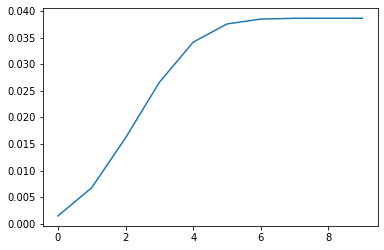

In [43]:
plt.plot(np.array(M_hist).squeeze())

In [148]:
%matplotlib tk
# print (os.getcwd())
solver = readwritedatafiles.read_data_file(f"v0_pboundary_{560}.pkl")
# solver.state_coeffs[solver.bface_helpers.elem_IDs[solver.mesh.boundary_groups["x1"].number], :, :]
# plt.plot(solver.state_coeffs[:,:,3].squeeze())
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
a = solver.physics.compute_variable("SoundSpeed", solver.state_coeffs)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
M = u / a
plt.plot(p.squeeze(), '.')
# solver.state_coeffs[300,:,:]
# plt.plot(solver.state_coeffs[:,:,1].squeeze(), '.')
U_chamber = np.array([
			0,
			1.2*1.257556105882443e+00,
      1.2*2.400000011294172e+03,
			0,													# Replaced variable
      1.2*7.202297102593764e+09,
			1.2*4.562862152986715e+01, # Abundance of total water
      1.2*4.307867810200626e+01])
to_y = lambda q: q / q[0:3].sum(axis=-1)
to_p = lambda q: solver.physics.compute_variable("Pressure", q)
to_y(solver.state_coeffs[0,0,:]), to_y(U_chamber[:])

# p_interior = to_p(solver.state_coeffs[0:1,:,:])
# p_boundary = to_p(np.expand_dims(U_chamber,(0,1)))
# (solver.state_coeffs[0:1,:,4:5] + p_interior)/solver.state_coeffs[0:1,:,0:3].sum(axis=-1), \
  # (U_chamber[4] + p_boundary)/U_chamber[0:3].sum()
# (solver.state_coeffs[0,0,:]), (U_chamber[:])
# solver.state_coeffs[0,0,:] + 0.5*(solver.state_coeffs[0,0,:] - solver.state_coeffs[1,0,:]), (U_chamber[:])

# solver = readwritedatafiles.read_data_file(f"v0_pboundary_25.pkl")
# Quick visualization
# Generate animation
# mdtools.generate_anim([], ["v0_pboundary"], "inbound_test", 22,
  # "pDensityWv", filter=lambda x, x0: x, initial=1, stride=10, is_high_detail=False)

(array([0.000000000000000e+00, 6.591164596599403e-04,
        9.993408835403400e-01, 1.537012381506709e+02,
        2.992088319745068e+06, 2.095235417006565e-02,
        2.385154251708710e-02]),
 array([0.000000000000000e+00, 5.237072952753058e-04,
        9.994762927047247e-01, 0.000000000000000e+00,
        2.999385488826175e+06, 1.900196886386962e-02,
        1.794004886724810e-02]))

In [ ]:
# Construction of final state using putative Riemann invariants
# cons1 = u + a / beta
# cons2 = entropy
# yA
# yWv
# yWt
# yC

In [56]:
# np.einsum("ijk, ijk -> ij", dpdU_fn(U), f(U)), dpdU_fn(U), f(U)
# dpdU_fn(U).ravel() @ f(U).ravel()
# p_hist
# U[:,:,3] / U[:,:,0:3].sum(axis=2, keepdims=True)
# solver.physics.compute_additional_variable("SoundSpeed", U, True)

# dU = damped_step_size * np.einsum("i, ijkl -> jkl", w, k)
# f(U_init)
# f(U_init) - k[0,:,:]
# f(U_init + 1/5 * damped_step_size * k[0,:,:]) - k[1,:,:]
# f(U_init + 3/40 * damped_step_size * k[0,:,:] + 9/40 * damped_step_size * k[1,:,:]) - k[2,:,:]

# i
plt.figure(1)
plt.clf()
# plt.plot((np.array(yWt_hist)*np.array(aux_hist)).ravel())
plt.subplot(3,2,1)
plt.plot(np.array(S_hist).ravel())
plt.ylabel("S (J/kgK)")
plt.subplot(3,2,2)
plt.plot(np.array(y1_hist).ravel())
plt.ylabel("y_1")
plt.subplot(3,2,3)
plt.plot(np.array(y2_hist).ravel())
plt.ylabel("y_2")
plt.subplot(3,2,4)
plt.plot(np.array(yWt_hist).ravel())
plt.ylabel("y_Wt")
plt.subplot(3,2,5)
plt.plot(np.array(yC_hist).ravel())
plt.ylabel("y_C")
plt.subplot(3,2,6)
plt.plot(np.array(aux_hist).ravel())
plt.ylabel("u + a/beta")

for i in range(6):
  plt.subplot(3,2,i+1)
  plt.xlabel("Iter count")

plt.figure(2)
plt.clf()
plt.subplot(1,2,1)
plt.plot(np.array(p_hist).ravel())
plt.subplot(1,2,2)
plt.plot(np.array(M_hist).ravel())

p_fn(U_init)
solver.physics.compute_additional_variable("Psi1", U, True)

array([[[1.08300383543955]]])

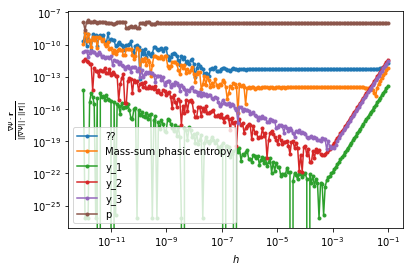

In [6]:
# Testing the generalized Riemann invariant condition
# From
#   dq == r dt
# Implying
#   dPsi/dq . dq == dPsi/dq . r dt ?= 0
# Then if dPsi/dq . r == 0 then Psi is a generalized Riemann invariant
# (see Embid  & Baer '92)

def entropy(U, physics):
    rho = U[:,:,0:3].sum(axis=2)
    y1 = U[:,:,0] / rho
    y2 = U[:,:,1] / rho
    y3 = U[:,:,2] / rho
    rhoA = U[:,:,0]/physics.compute_additional_variable("volFracA", U, True).squeeze(axis=2)
    rhoWv = U[:,:,1]/physics.compute_additional_variable("volFracWv", U, True).squeeze(axis=2)
    p = physics.compute_additional_variable("Pressure", U, True).squeeze(axis=2)
    T = physics.compute_additional_variable("Temperature", U, True).squeeze(axis=2)
    S = y1 * physics.Gas[0]["c_v"] * np.log(p / rhoA**physics.Gas[0]["gamma"]) + \
        y2 * physics.Gas[1]["c_v"] * np.log(p / rhoWv**physics.Gas[1]["gamma"]) + \
        y3 * physics.Liquid["c_m"] * np.log(T) \
    # Mixing related entropy, convex function of y1, y2
    # -x * log(x/(x+y)) has Hessian eigenvals 0, (x^2 + y^2) / (x (x + y)^2)
    S_mix = -y1 * physics.Gas[0]["R"] * np.log(y1 * physics.Gas[0]["R"] / (y1 * physics.Gas[0]["R"] + y2 * physics.Gas[1]["R"])) \
        -y2 * physics.Gas[1]["R"] * np.log(y2 * physics.Gas[1]["R"] / (y1 * physics.Gas[0]["R"] + y2 * physics.Gas[1]["R"]))
    return S

def compute_left_eig(U, physics):
  ''' Compute hyperbolic subsystem modal matrix '''
  R = physics.get_conv_eigenvectors(U)
  R_hyp = R[:,:,0:5,0:5]
  L_hyp = np.linalg.inv(R_hyp)
  # Right eigenvector corresponding to
  # R_hyp[:,:,:,3] # 3: u - a
  # np.einsum("ij, j", L_hyp, R_hyp[:,4])
  # Left eigenvector corresponding to
  # L_hyp[:,:,3,:]
  new_shape = list(L_hyp[:,:,3:4,:].shape)
  new_shape[3] += 2
  l_full = np.zeros(new_shape)
  l_full[:,:,:,0:5] = L_hyp[:,:,3:4,:]
  return l_full

# Centered difference for gradient
def evaluate_orthogonality(U, diff_eps, physics, quant="acou", strat="cent2",
    is_normalized=True):
  if quant == "acou":
    # Set tentative Riemann invariant to u - a / beta
    Psi = lambda U : (U[:,:,3] / U[:,:,0:3].sum(axis=2)) + \
      physics.compute_additional_variable("SoundSpeed", U, True).squeeze(axis=2) / \
      physics.compute_additional_variable("beta", U, True).squeeze(axis=2)
  elif quant == "entropy":
    # Set tentative Riemann invariant to entropy
    Psi = lambda U : entropy(U, physics)
  elif quant == "y1":
    Psi = lambda U: U[:,:,0] / (U[:,:,0:3].sum(axis=2))
  elif quant == "y2":
    Psi = lambda U: U[:,:,1] / (U[:,:,0:3].sum(axis=2))
  elif quant == "y3":
    Psi = lambda U: U[:,:,2] / (U[:,:,0:3].sum(axis=2))
  elif quant == "pressure":
    Psi = lambda U: physics.compute_additional_variable("Pressure", U, True).squeeze(axis=2)
    # Psi = lambda U: solver.physics.compute_additional_variable("SoundSpeed", U, True).squeeze(axis=2)
  else:
    raise Exception

  # Set finite difference step
  scaling_vec = diff_eps*U.squeeze()
  dU = np.expand_dims(np.diag(scaling_vec),axis=0)

  if strat == "cent2":
    scaling_vec[np.where(scaling_vec == 0)] = 1e-14
    # Centered difference
    gradPsi = (Psi((U+dU/2)) - Psi((U-dU/2))) / (scaling_vec)
  elif strat == "cent4":
    scaling_vec[np.where(scaling_vec == 0)] = 1e-14
    # HO Centered difference
    gradPsi = (
      -Psi(U+2*dU)
      +8*Psi(U+dU)
      -8*Psi(U-dU)
      +Psi(U-2*dU)) / (12*scaling_vec)
  else:
    raise Exception

  if is_normalized:
    x = compute_eig_aco_negative(U, physics).squeeze()
    return np.dot(gradPsi.squeeze(), x) / (np.linalg.norm(gradPsi.squeeze())
        * np.linalg.norm(x))
  else:
    return np.dot(gradPsi.squeeze(), 
      compute_eig_aco_negative(U, physics).squeeze())

# Centered difference for gradient
def evaluate_parallel(U, diff_eps, physics, quant="acou", strat="cent2",
    is_normalized=True):
  if quant == "acou":
    # Set tentative Riemann invariant to u - a / beta
    Psi = lambda U : (U[:,:,3] / U[:,:,0:3].sum(axis=2)) + \
      physics.compute_additional_variable("SoundSpeed", U, True).squeeze(axis=2) / \
      physics.compute_additional_variable("beta", U, True).squeeze(axis=2)
  elif quant == "entropy":
    # Set tentative Riemann invariant to entropy
    Psi = lambda U : entropy(U, physics)
  elif quant == "y1":
    Psi = lambda U: U[:,:,0] / (U[:,:,0:3].sum(axis=2))
  elif quant == "y2":
    Psi = lambda U: U[:,:,1] / (U[:,:,0:3].sum(axis=2))
  elif quant == "y3":
    Psi = lambda U: U[:,:,2] / (U[:,:,0:3].sum(axis=2))
  elif quant == "pressure":
    Psi = lambda U: physics.compute_additional_variable("Pressure", U, True).squeeze(axis=2)
    # Psi = lambda U: solver.physics.compute_additional_variable("SoundSpeed", U, True).squeeze(axis=2)
  else:
    raise Exception

  # Set finite difference step
  scaling_vec = diff_eps*U.squeeze()
  dU = np.expand_dims(np.diag(scaling_vec),axis=0)

  if strat == "cent2":
    scaling_vec[np.where(scaling_vec == 0)] = 1e-14
    # Centered difference
    gradPsi = (Psi((U+dU/2)) - Psi((U-dU/2))) / (scaling_vec)
  elif strat == "cent4":
    scaling_vec[np.where(scaling_vec == 0)] = 1e-14
    # HO Centered difference
    gradPsi = (
      -Psi(U+2*dU)
      +8*Psi(U+dU)
      -8*Psi(U-dU)
      +Psi(U-2*dU)) / (12*scaling_vec)
  else:
    raise Exception

  if is_normalized:
    x = compute_left_eig(U, physics).squeeze()
    return np.dot(gradPsi.squeeze(), x) / (np.linalg.norm(gradPsi.squeeze())
        * np.linalg.norm(x))
  else:
    return np.dot(gradPsi.squeeze(), 
      compute_left_eig(U, physics).squeeze())

# State vector to sus out
U_sus = U.copy()
# U_sus[:,:,2] = 0

diff_eps = np.logspace(-12,-1,200)
orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="acou",strat="cent4")))
orthos = np.array(orthos)

plt.figure(3)
plt.clf()
line1, = plt.loglog(diff_eps, orthos, '.-', label="??")

orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="entropy",strat="cent4")))
orthos = np.array(orthos)
line2, = plt.loglog(diff_eps, orthos, '.-', label="Mass-sum phasic entropy")

orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="y1",strat="cent4")))
orthos = np.array(orthos)
line3, = plt.loglog(diff_eps, orthos, '.-', label="y_1")

orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="y2",strat="cent4")))
orthos = np.array(orthos)
line4, = plt.loglog(diff_eps, orthos, '.-', label="y_2")

orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="y3",strat="cent4")))
orthos = np.array(orthos)
line5, = plt.loglog(diff_eps, orthos, '.-', label="y_3")

orthos = []
for i, e in enumerate(diff_eps):
  orthos.append(abs(evaluate_orthogonality(U_sus,e,solver.physics,quant="pressure",strat="cent4")))
orthos = np.array(orthos)
line6, = plt.loglog(diff_eps, orthos, '.-', label="p")

# plt.ylim([1e-10, 1e5])
# orthos.min()
# solver.physics.compute_additional_variable("beta", U, True)

plt.xlabel("$h$")
plt.ylabel("$\\frac{\\nabla \\Psi \\cdot \\mathbf{r}} {|| \\nabla \\Psi || \\cdot  || \\mathbf{r} ||}$")
plt.legend(handles=[line1, line2, line3, line4, line5, line6])

In [76]:
# Solution sampling for testing invariants
sampling_range = range(1,375)
quant_keys = ["acou", "entropy", "y1", "y2", "y3", "pressure"]
d_quant_orthogs = {}
for quant in quant_keys:
  d_quant_orthogs[quant] = []
M_hist = []

for plot_idx in sampling_range:
  solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")
  U_sampled = solver_conduit1.state_coeffs[solver_conduit1.bface_helpers.elem_IDs[solver_conduit1.mesh.boundary_groups["x2"].number], :, :]
  for quant in quant_keys:
    # d_quant_orthogs[quant].append(abs(evaluate_parallel(U_sampled,1e-4,solver_conduit1.physics,quant=quant,strat="cent4")))
    d_quant_orthogs[quant].append(abs(evaluate_orthogonality(U_sampled,1e-4,solver_conduit1.physics,quant=quant,strat="cent4")))
  M_hist.append(solver_conduit1.physics.compute_additional_variable("XVelocity", U_sampled, True)
    / solver_conduit1.physics.compute_additional_variable("SoundSpeed", U_sampled, True)
  )


In [77]:
%matplotlib tk
plt.figure(4)
plt.clf()
plt.subplot(2,1,1)
lines = []
for i, quant in enumerate(quant_keys):
  # Special naming for acou
  label = quant
  if quant == "acou":
    label = "$u + a/\\beta$"
  elif quant == "pressure":
    label = "p (negative control)"
  line, = plt.semilogy(np.array(d_quant_orthogs[quant]), '.-', label=label)
  lines.append(line)
plt.legend(handles=lines, bbox_to_anchor=(0.75, 0.5))
plt.title("Cosines at boundary for 2D1D coupled, sampled over saved files")
plt.ylabel("$\\frac{\\nabla \\Psi \\cdot \\mathbf{r}} {|| \\nabla \\Psi || \\cdot  || \\mathbf{r} ||}$")

plt.subplot(2,1,2)
plt.plot(np.array(M_hist).squeeze())
plt.xlabel("Save file index")
plt.ylabel("Mach")

Text(0, 0.5, 'Mach')

In [ ]:
u1 = U_init[:,:,3] / U_init[:,:,0:3].sum()
a1 = solver.physics.compute_additional_variable("SoundSpeed", U_init, True)
beta1 = solver.physics.compute_additional_variable("beta", U_init, True)
Gamma1 = solver.physics.compute_additional_variable("Gamma", U_init, True)
u2 = U[:,:,3] / U[:,:,0:3].sum()
a2 = solver.physics.compute_additional_variable("SoundSpeed", U, True)
beta2 = solver.physics.compute_additional_variable("beta", U, True)
Gamma2 = solver.physics.compute_additional_variable("Gamma", U, True)
u1 + a1*2/(Gamma1-1), u2 + a2*2/(Gamma2-1)

In [54]:
def compute_left_eig(U, physics):
  ''' Compute hyperbolic subsystem modal matrix '''
  R = physics.get_conv_eigenvectors(U)
  R_hyp = R[:,:,0:5,0:5]
  L_hyp = np.linalg.inv(R_hyp)
  # Right eigenvector corresponding to
  # R_hyp[:,:,:,3] # 3: u - a
  # np.einsum("ij, j", L_hyp, R_hyp[:,4])
  # Left eigenvector corresponding to
  # L_hyp[:,:,3,:]
  new_shape = list(L_hyp[:,:,3:4,:].shape)
  new_shape[3] += 2
  l_full = np.zeros(new_shape)
  l_full[:,:,:,0:5] = L_hyp[:,:,3:4,:]
  return l_full

def compute_eig(U, physics):
  '''Compute rows of flux Jacobian for tracer states'''
  # Row of flux Jacobian for tracer states
  rho = U[:,:,physics.get_mass_slice()].sum(axis=2)
  u = U[:,:,physics.get_state_index("XMomentum")] / rho
  # Truncated row of flux Jacobian for tracer states
  #   b = [-u, -u, -u, 1, 0] / rho * q_i
  # where q_i is the partial density of the given tracer state
  N_states_hyperbolic = 5
  N_states_tracer = 2
  # Fill temporary construction vector with size [ne, nq, ns_hyp]
  b_sub = np.tile(np.zeros_like(u), (1,1,N_states_hyperbolic))
  b_sub[:,:,physics.get_mass_slice()] = -u/rho
  b_sub[:,:,physics.get_state_index("XMomentum")] = 1.0/rho
  # Fill temporary construction vector with size [ne, nq, ns_tracer]
  slice_like_tracers = (physics.get_state_index("pDensityWt"), 
    physics.get_state_index("pDensityC"))
  arho_tracers = U[:,:,slice_like_tracers]
  # Compute rows of flux Jacobian for tracer states
  b = np.einsum("ijk, ijl -> ijkl", arho_tracers, b_sub)

  ''' Compute u-c eigenvector of hyperbolic subsystem '''
  # Size [ne, nq, ns_hyp]
  #   x = y1 y2 y3 u-a H - au
  # Mass fractions
  y1 = U[:,:,0] / rho
  y2 = U[:,:,1] / rho
  y3 = U[:,:,2] / rho
  eigvec_hyp = np.zeros_like(b_sub)
  H = physics.compute_additional_variable("TotalEnthalpy", U, True)
  a = physics.compute_additional_variable("SoundSpeed", U, True)
  eigvec_hyp[:,:,0] = y1
  eigvec_hyp[:,:,1] = y2
  eigvec_hyp[:,:,2] = y3
  eigvec_hyp[:,:,3] = u - a
  eigvec_hyp[:,:,4] = H - a*u

  ''' Compute extension of the hyperbolic subsystem acoustic eigenvector'''
  # Compute (b^T * eigvec) / (eigval - u) -- 
  eigvec_ext = np.einsum("ijkl, ijl -> ijk", b, eigvec_hyp) / (-a)

  return np.concatenate((eigvec_hyp, eigvec_ext), axis=2)

In [61]:
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{0}.pkl")
U_b = solver_conduit1.state_coeffs[solver_conduit1.bface_helpers.elem_IDs[solver_conduit1.mesh.boundary_groups["x2"].number], :, :]

# Right eig vector, [ne, nb, ns]
x = compute_eig(U_b, solver_conduit1.physics)
# Left eig vector, [ne, nb, 1, ns]
y = compute_left_eig(U_b, solver_conduit1.physics)
#   return np.dot(gradPsi.squeeze(), x) / (np.linalg.norm(gradPsi.squeeze())
#       * np.linalg.norm(x))
# else:
#   return np.dot(gradPsi.squeeze(), 
#     compute_eig_aco_negative(U, physics).squeeze())
np.dot(x.squeeze(),y.squeeze())

1.0

In [789]:
# Scalar quadrature for Riemann invariant
def entropy(U, physics):
    rho = U[:,:,0:3].sum(axis=-1)
    y1 = U[:,:,0] / rho
    y2 = U[:,:,1] / rho
    y3 = U[:,:,2] / rho
    rhoA = 1e-11 + physics.compute_variable("pDensityA", U).squeeze(axis=-1)
    rhoWv = 1e-11 + physics.compute_variable("pDensityWv", U).squeeze(axis=-1)
    p = physics.compute_additional_variable("Pressure", U, True).squeeze(axis=-1)
    T = physics.compute_additional_variable("Temperature", U, True).squeeze(axis=-1)
    S = y1 * physics.Gas[0]["c_v"] * np.log(p / rhoA**physics.Gas[0]["gamma"]) + \
        y2 * physics.Gas[1]["c_v"] * np.log(p / rhoWv**physics.Gas[1]["gamma"]) + \
        y3 * physics.Liquid["c_m"] * np.log(T)
    return S

def curve_f(U, p, physics, T0, p0, is_p_preshaped=False):
    rho = U[:, :, 0:3].sum(axis=2)
    y1 = U[:, :, 0] / rho
    y2 = U[:, :, 1] / rho
    y3 = U[:, :, 2] / rho
    am2 = physics.Liquid["K"] / physics.Liquid["rho0"]
    yR_g = y1 * physics.Gas[0]["R"] + y2 * physics.Gas[1]["R"]
    Gamma = physics.compute_variable("Gamma", U).squeeze(axis=2)

    ''' Return output with shape (ne, nb, np) where np is the dimension of vector p''' 
    if is_p_preshaped:
        return np.sqrt(
            np.einsum("ij, ijk -> ijk", yR_g / Gamma * T0 / p0**((Gamma-1.0)/Gamma),
                p**np.expand_dims((-1.0-Gamma)/Gamma, axis=2))
            + np.einsum("ij, ijk -> ijk", y3 * am2, 
                1.0/((p - physics.Liquid["p0"] + physics.Liquid["K"]) *
                    (p - physics.Liquid["p0"] + physics.Liquid["K"]))))
    ppower = p**np.expand_dims((-1.0-Gamma)/Gamma, axis=-1)
    return np.sqrt(
        np.einsum("ij, ijk -> ijk", 
            yR_g / Gamma * T0 / p0**((Gamma-1.0)/Gamma),
            ppower)
        + np.einsum("ij, k -> ijk",
            y3 * am2, 
            1.0/((p - physics.Liquid["p0"] + physics.Liquid["K"]) *
                 (p - physics.Liquid["p0"] + physics.Liquid["K"]))))

solver = readwritedatafiles.read_data_file(f"v0_pboundary_0.pkl")
U = solver.state_coeffs

In [64]:
''' Define scalar quadrature construction of pressure boundary ''' 

import scipy
def new_method(p_bdry, U, solver, is_adaptive=True, tol=1e-1, rtol=1e-5):
  T0 = solver.physics.compute_variable("Temperature", U).squeeze(axis=2)
  p0 = solver.physics.compute_variable("Pressure", U).squeeze(axis=2)
  Gamma0 = solver.physics.compute_variable("Gamma", U).squeeze(axis=2)
  rho = U[:, :, 0:3].sum(axis=2)
  y1 = U[:, :, 0] / rho
  y2 = U[:, :, 1] / rho
  y3 = U[:, :, 2] / rho

  # Set boundary pressure equal to specified pressure function
  pHat = p_bdry
  # Set initial value for velocity, updated with subsequent quadrature
  uHat = solver.physics.compute_variable("XVelocity", U).squeeze(axis=2)

  # Define derivative of Riemann invariant with respect to p 
  def curve_f(U, p, physics, T0, p0, y1, y2, y3, Gamma, is_p_preshaped=False):
    am2 = physics.Liquid["K"] / physics.Liquid["rho0"]
    yR_g = y1 * physics.Gas[0]["R"] + y2 * physics.Gas[1]["R"]

    ''' Return output with shape (ne, nb, np) where np is the dimension of vector p''' 
    if is_p_preshaped:
        return np.sqrt(
            np.einsum("ij, ijk -> ijk", yR_g / Gamma * T0 / p0**((Gamma-1.0)/Gamma),
                p**np.expand_dims((-1.0-Gamma)/Gamma, axis=2))
            + np.einsum("ij, ijk -> ijk", y3 * am2, 
                1.0/((p - physics.Liquid["p0"] + physics.Liquid["K"]) *
                    (p - physics.Liquid["p0"] + physics.Liquid["K"]))))
    ppower = p**np.expand_dims((-1.0-Gamma)/Gamma, axis=-1)
    return np.sqrt(
        np.einsum("ij, ijk -> ijk", 
            yR_g / Gamma * T0 / p0**((Gamma-1.0)/Gamma),
            ppower)
        + np.einsum("ij, k -> ijk",
            y3 * am2, 
            1.0/((p - physics.Liquid["p0"] + physics.Liquid["K"]) *
                 (p - physics.Liquid["p0"] + physics.Liquid["K"]))))

  ''' Adaptive Gauss quadrature '''
  if is_adaptive:
    for i in range(U.shape[0]):
      for j in range(U.shape[1]):
        uHat[i,j] += scipy.integrate.quadrature(lambda p: curve_f(
          U[i:i+1,j:j+1,:], p, solver.physics,
          T0[i:i+1,j:j+1], p0[i:i+1,j:j+1],
          y1[i:i+1,j:j+1], y2[i:i+1,j:j+1], y3[i:i+1,j:j+1],
          Gamma0[i:i+1,j:j+1]).squeeze(axis=(0,1)),
          p_bdry, p0[i,j], tol=tol, rtol=rtol)[0]
  else:
    ''' Full-stride Gauss quadrature for ODE of type dF/dp = f(p) '''
    x_nodes = np.array([-1, -np.sqrt(3/7), 0, np.sqrt(3/7), 1])
    w = np.array([1/10, 49/90, 32/45, 49/90, 1/10])
    # Affine mapping
    p_nodes = np.expand_dims(0.5*(p0 + p_bdry), axis=-1) \
      + np.einsum("..., k -> ...k", 0.5*(p0 - p_bdry), x_nodes)
    # Define function f(p)
    f = lambda p: curve_f(U, p_nodes, solver.physics,
      T0, p0, y1, y2, y3, Gamma0, is_p_preshaped=True)
    # Perform Gauss quadrature
    #   Multiply f, weights in [-1, 1], jacobian of affine map [-1,1]->[p_bdry, p0]
    uHat += np.einsum("...k, k, ...", f(p_nodes), w, 0.5*(p0 - p_bdry))


  # N_temp = 1000
  # dp = (p0 - p_bdry) / N_temp
  # for i in range (N_temp):
  #   uHat += dp*curve_f(U, pHat + i*dp, solver.physics, T0, p0)

  # Isentropic
  THat = T0 * (pHat / p0) **((Gamma0-1)/Gamma0)
  return(pHat, uHat, THat)


In [841]:
# ff = lambda p: curve_f(U[i:i+1,j:j+1,:], p, solver.physics, T0[i:i+1,j:j+1], p0[i:i+1,j:j+1])
# p_bdry, p0[i,j]
# U[i,j,:].shape
# ff(np.array([1]))
zzz = new_method(p_bdry, U, solver, is_adaptive=False)


In [62]:
def compute_eig_aco_negative(U, physics):
			''' Computes eigenvector corresponding to u-c'''

			'''Compute rows of flux Jacobian for tracer states'''
			# Row of flux Jacobian for tracer states
			rho = U[:,:,physics.get_mass_slice()].sum(axis=2, keepdims=True)
			u = U[:,:,physics.get_momentum_slice()] / rho
			# Truncated row of flux Jacobian for tracer states
			#   b = [-u, -u, -u, 1, 0] / rho * q_i
			# where q_i is the partial density of the given tracer state
			N_states_hyperbolic = 5
			N_states_tracer = 2
			# Fill temporary construction vector with size [ne, nq, ns_hyp]
			# b_sub = np.tile(np.zeros_like(u), (1,1,N_states_hyperbolic))
			b_sub = np.zeros((*U[:,:,0].shape,N_states_hyperbolic))
			b_sub[:,:,physics.get_mass_slice()] = -u/rho
			b_sub[:,:,physics.get_momentum_slice()] = 1.0/rho
			# Fill temporary construction vector with size [ne, nq, ns_tracer]
			slice_like_tracers = (physics.get_state_index("pDensityWt"), 
				physics.get_state_index("pDensityC"))
			arho_tracers = U[:,:,slice_like_tracers]
			# Compute rows of flux Jacobian for tracer states
			b = np.einsum("ijk, ijl -> ijkl", arho_tracers, b_sub)

			''' Compute u-c eigenvector of hyperbolic subsystem '''
			# Size [ne, nq, ns_hyp]
			#   x = y1 y2 y3 u-a H - au
			# Mass fractions
			y1 = U[:,:,0:1] / rho
			y2 = U[:,:,1:2] / rho
			y3 = U[:,:,2:3] / rho
			eigvec_hyp = np.zeros_like(b_sub)
			H = physics.compute_additional_variable("TotalEnthalpy", U, True)
			a = physics.compute_additional_variable("SoundSpeed", U, True)
			eigvec_hyp[:,:,0:1] = y1
			eigvec_hyp[:,:,1:2] = y2
			eigvec_hyp[:,:,2:3] = y3
			eigvec_hyp[:,:,3:4] = u - a
			eigvec_hyp[:,:,4:5] = H - a*u

			''' Compute extension of the hyperbolic subsystem acoustic eigenvector'''
			# Compute (b^T * eigvec) / (eigval - u) -- 
			eigvec_ext = np.einsum("ijkl, ijl -> ijk", b, eigvec_hyp) / (-a)
			return np.concatenate((eigvec_hyp, eigvec_ext), axis=2)

def brute_force_integration(p_target, UqB, solver):
		UqB = UqB.copy()
		physics = solver.physics
		damping_idx_scale = 5
		additional_damping_factor = 1.0
		N_steps_max = 20
		# Permissive step count
		N_steps_max = np.max([N_steps_max, 10*damping_idx_scale])
		p_rel_tol = 1e-4

		# Initialize monitor variables for measuring relative change
		p = 1e-15
		p_last = 1e15
		stuck_counter = 0

		p_fn = lambda U : physics.compute_additional_variable("Pressure", U, True)
		dpdU_fn = lambda U : physics.compute_pressure_sgradient(U)
		f = lambda U: compute_eig_aco_negative(U, physics)

		for i in range(N_steps_max):
			''' Set damped Newton step size '''
			# Discrete Gaussian damping
			damping = 1.0 - np.exp(-((i+1)/damping_idx_scale)**2)
			damping *= additional_damping_factor
			# Compute Newton step size
			newton_step_size = (p_target - p_fn(UqB)) / \
					np.expand_dims(np.einsum("ijk, ijk -> ij", dpdU_fn(UqB), f(UqB)),axis=2)
			# Check for stalling
			# if (p - p_last) / p_target < p_rel_tol and i > 2 * damping_idx_scale:
			#     # Increase damping (high damping for monotonic approach to target)
			#     # (Deterministic alternative to stochastic perturbation)
			#     damping *= (0.9)**(stuck_counter+1)
			#     stuck_counter += 1
			p_last = p

			# Butcher table for Cash-Karp RK quadrature
			B = np.array([[1/5, 0, 0, 0, 0],
					[3/40, 9/40, 0, 0, 0],
					[3/10, -9/10, 6/5, 0, 0],
					[-11/54, 5/2, -70/27, 35/27, 0],
					[1631/55296, 175/512, 575/13824, 44275/110592, 253/4096]])
			w = np.array([37/378, 0, 250/621, 125/594 , 0, 512/1771])
			# Compute damped step size for ODE integration
			damped_step_size = damping * newton_step_size
			# RK step 0
			num_stages = B.shape[0] + 1
			k = np.zeros(tuple(np.append([num_stages], list(UqB.shape))))
			k[0,:,:,:] = f(UqB)
			for j in range(B.shape[0]):
					k[j+1,:,:,:]= f(UqB + damped_step_size*
							np.einsum("m, mijk -> ijk", B[j,0:j+1], k[0:j+1,:]))
			UqB += damped_step_size * np.einsum("i, ijkl -> jkl", w, k)
			p = p_fn(UqB)

			# print(f"Step {i}")
			# if np.all(np.abs(p - p_target) / p_target < p_rel_tol):
			# 	break

		return UqB

In [77]:
# Moderate pressure difference test
import time

# Test against a single state vector
U = solver.state_coeffs[:1,:1,:]
p_bdry = 0.7e7
N_reps = 100


t0 = time.perf_counter()
for i in range(N_reps):
  U1 = brute_force_integration(p_bdry, U, solver)
t1 = time.perf_counter()
for i in range(N_reps):
  p2, u2, T2 = new_method(p_bdry, U, solver)
t2 = time.perf_counter()
for i in range(N_reps):
  p3, u3, T3 = new_method(p_bdry, U, solver, is_adaptive=False)
t3 = time.perf_counter()

import physics.multiphasevpT.atomics as atomics
for i in range(N_reps*U.shape[0]*U.shape[1]):
  p4, u4, T4 = atomics.velocity_RI_fixed_p_quadrature(p_bdry, U[:1,:1,:], solver.physics)
t4 = time.perf_counter()

get_quant = lambda U, str: solver.physics.compute_variable(str, U)
p0 = get_quant(U, "Pressure")
T0 = get_quant(U, "Temperature")
u0 = get_quant(U, "XVelocity")
p1 = get_quant(U1, "Pressure")
T1 = get_quant(U1, "Temperature")
u1 = get_quant(U1, "XVelocity")
print("Grid value:")
print(p0[0,0,0], u0[0,0,0], T0[0,0,0], p0[-1,0,0], u0[-1,0,0], T0[-1,0,0],)
print("0th element: p | u | T, last element: p | u | T ")
print(p1[0,0,0], u1[0,0,0], T1[0,0,0], p1[-1,0,0], u1[-1,0,0], T1[-1,0,0],)
print(p2, u2[0,0], T2[0,0], p2, u2[-1,0], T2[-1,0],)
print(p3, u3[0,0], T3[0,0], p3, u3[-1,0], T3[-1,0],)
print(p4, u4[0,0], T4[0,0],)
print("Timings")
print(f'''ODE system: {(t1-t0)/N_reps*1e3} ms;
scalar quadrature: {(t2-t1)/N_reps*1e3} ms
scalar quadrature (oneshot): {(t3-t2)/N_reps*1e3} ms
scalar quadrature (scalar-opt): {(t4-t3)/N_reps*1e3} ms
''')

Grid value:
222554674.3344555 2.1314865247231786e-06 999.9999977266747 222554674.3344555 2.1314865247231786e-06 999.9999977266747
0th element: p | u | T, last element: p | u | T 
7000000.0 164.93431992325537 997.353810225549 7000000.0 164.93431992325537 997.353810225549
7000000.0 164.8911585017158 997.6727587382595 7000000.0 164.8911585017158 997.6727587382595
7000000.0 184.69863127752507 997.6727587382595 7000000.0 184.69863127752507 997.6727587382595
7000000.0 [164.88515635248123] [997.6727587382595]
Timings
ODE system: 116.31884399997944 ms;
scalar quadrature: 0.6374270000014803 ms
scalar quadrature (oneshot): 0.16915700001845835 ms
scalar quadrature (scalar-opt): 0.4666730000099051 ms



In [78]:
# Small pressure difference test
import time

# Test against a single state vector
U = solver.state_coeffs[:1,:1,:]
p_bdry = 10e7 # Closer to U
N_reps = 100


t0 = time.perf_counter()
for i in range(N_reps):
  U1 = brute_force_integration(p_bdry, U, solver)
t1 = time.perf_counter()
for i in range(N_reps):
  p2, u2, T2 = new_method(p_bdry, U, solver)
t2 = time.perf_counter()
for i in range(N_reps):
  p3, u3, T3 = new_method(p_bdry, U, solver, is_adaptive=False)
t3 = time.perf_counter()

import physics.multiphasevpT.atomics as atomics
for i in range(N_reps*U.shape[0]*U.shape[1]):
  p4, u4, T4 = atomics.velocity_RI_fixed_p_quadrature(p_bdry, U[:1,:1,:], solver.physics)
t4 = time.perf_counter()

get_quant = lambda U, str: solver.physics.compute_variable(str, U)
p0 = get_quant(U, "Pressure")
T0 = get_quant(U, "Temperature")
u0 = get_quant(U, "XVelocity")
p1 = get_quant(U1, "Pressure")
T1 = get_quant(U1, "Temperature")
u1 = get_quant(U1, "XVelocity")
print("Grid value:")
print(p0[0,0,0], u0[0,0,0], T0[0,0,0], p0[-1,0,0], u0[-1,0,0], T0[-1,0,0],)
print("0th element: p | u | T, last element: p | u | T ")
print(p1[0,0,0], u1[0,0,0], T1[0,0,0], p1[-1,0,0], u1[-1,0,0], T1[-1,0,0],)
print(p2, u2[0,0], T2[0,0], p2, u2[-1,0], T2[-1,0],)
print(p3, u3[0,0], T3[0,0], p3, u3[-1,0], T3[-1,0],)
print(p4, u4[0,0], T4[0,0],)
print("Timings")
print(f'''ODE system: {(t1-t0)/N_reps*1e3} ms;
scalar quadrature: {(t2-t1)/N_reps*1e3} ms
scalar quadrature (oneshot): {(t3-t2)/N_reps*1e3} ms
scalar quadrature (scalar-opt): {(t4-t3)/N_reps*1e3} ms
''')

Grid value:
222554674.3344555 2.1314865247231786e-06 999.9999977266747 222554674.3344555 2.1314865247231786e-06 999.9999977266747
0th element: p | u | T, last element: p | u | T 
100000000.0000019 43.47551661014511 999.2071374715517 100000000.0000019 43.47551661014511 999.2071374715517
100000000.0 43.47951834421183 999.4613092381809 100000000.0 43.47951834421183 999.4613092381809
100000000.0 43.482717748594496 999.4613092381809 100000000.0 43.482717748594496 999.4613092381809
100000000.0 [43.474919011366985] [999.4613092381809]
Timings
ODE system: 115.8549039999707 ms;
scalar quadrature: 0.2610160000040196 ms
scalar quadrature (oneshot): 0.1655610000307206 ms
scalar quadrature (scalar-opt): 0.1863519999824348 ms



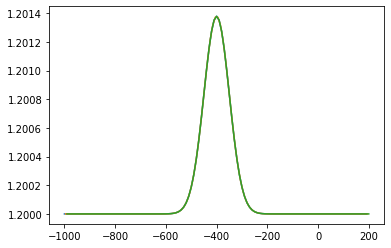

In [225]:
# Test isentropic pulse

# Hook from existing solver
physics = solver.physics
mesh = solver.mesh
stepper = solver.stepper

# Generate state
U = solver.state_coeffs.copy()
T_test = 300
U[...,0] = 1.2
U[...,1:3] = 0

Gamma = atomics.Gamma(U[...,0:3], physics)
gas_volfrac = atomics.gas_volfrac(U[...,0:3], T_test, physics)
p = atomics.pressure(U[...,0:3], T_test, gas_volfrac, physics)

# Construct constant psi+
psi_plus = np.zeros_like(U[...,0:1])
# Construct pulse in psi-
# HACK
x =  plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis,
				True)
x = x[:,[0,3,-1],:]
x0 = -400
variance = 50
pulse_amplitude = 1e2
psi_minus = pulse_amplitude / (
  np.sqrt(2.*np.pi)*variance)*np.exp(-np.power((x - x0)/variance, 2.)/2)
u = 0.5*(psi_plus + psi_minus)
# Approximate p in pulse
f_bar = atomics.acousticRI_integrand_scalar(p[0,0,0], np.array([T_test]), p[0,0,0], 
  atomics.massfrac(U[...,0:3])[:1,:1,:], Gamma[0,0,0], physics)
p = p[0,0,0] + 0.5*(psi_minus - psi_plus) / f_bar
# Isentropic condition for temperature
T = T_test * (p/p[0,0,0]) ** ((Gamma-1)/Gamma)

U[...,0:1] = p / T / physics.Gas[0]["R"]
U[...,3:4] = atomics.rho(U[...,0:3]) * u
U[...,4:5] = atomics.c_v(U[...,0:3], physics) * T \
  + 0.5 * atomics.rho(U[...,0:3]) * u**2
U[...,5:] = 0

U_init = U.copy()
# plt.plot(x.squeeze(), U_init[...,3].squeeze())
# plt.plot(x.squeeze(), (U_init[...,3] / U_init[...,0] - p.squeeze() * f_bar).squeeze())
plt.clf()
# plt.plot(x.squeeze(), u.squeeze() - (p.squeeze() - p[0,0,0]) * f_bar)
# plt.plot(x.squeeze(), u.squeeze() + (p.squeeze() - p[0,0,0]) * f_bar)
# plt.legend(["1", "2"])

# Plot p / Z - u
# plt.plot(x.squeeze(), (p-p[0,0,0,]).squeeze() * f_bar - u.squeeze())
plt.plot(x.squeeze(), U[...,0].squeeze())

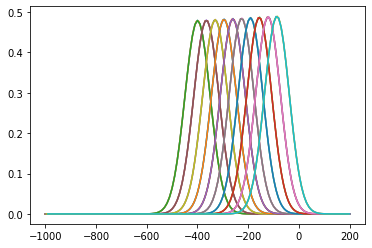

In [226]:
# Unboxed stepping
solver.state_coeffs = U_init.copy()
U = U_init.copy()
for i in range(1000):
  res = stepper.res
  if stepper.balance_const is None:
    res[:] = 0.
  else:
    res[:] = stepper.balance_const
  solver.params["SourceSwitch"] = False
  solver.get_element_residuals(U, res)
  solver.get_interior_face_residuals(U, res)
  dU = solver_tools.mult_inv_mass_matrix(mesh, solver, 10*solver.stepper.dt, res)
  U += dU
  U[0,:,:] = U[1,:,:]
  U[-1,:,:] = U[-2,:,:]
  if np.mod(i,100) == 0:
    plt.plot(x.squeeze(), U[...,3].squeeze())

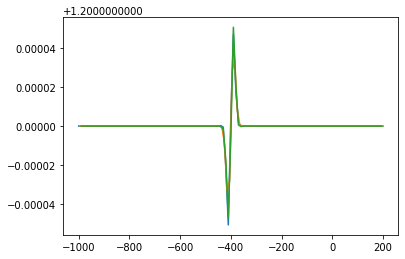

In [845]:
# Small pressure difference test (old)
import time

p_bdry = 10e7
N_reps = 10
t0 = time.perf_counter()
for i in range(N_reps):
  U1 = brute_force_integration(p_bdry, U, solver)
t1 = time.perf_counter()
for i in range(N_reps):
  p2, u2, T2 = new_method(p_bdry, U, solver)
t2 = time.perf_counter()
for i in range(N_reps):
  p3, u3, T3 = new_method(p_bdry, U, solver, is_adaptive=False)
t3 = time.perf_counter()

get_quant = lambda U, str: solver.physics.compute_variable(str, U)
p0 = get_quant(U, "Pressure")
T0 = get_quant(U, "Temperature")
u0 = get_quant(U, "XVelocity")
p1 = get_quant(U1, "Pressure")
T1 = get_quant(U1, "Temperature")
u1 = get_quant(U1, "XVelocity")
print(p0[0,0,0], u0[0,0,0], T0[0,0,0], p0[-1,0,0], u0[-1,0,0], T0[-1,0,0],)
print(p1[0,0,0], u1[0,0,0], T1[0,0,0], p1[-1,0,0], u1[-1,0,0], T1[-1,0,0],)
print(p2, u2[0,0], T2[0,0], p2, u2[-1,0], T2[-1,0],)
print(p3, u3[0,0], T3[0,0], p3, u3[-1,0], T3[-1,0],)
print(f'''ODE system: {(t1-t0)/N_reps} s; scalar quadrature: {(t2-t1)/N_reps} s
          scalar quadrature (oneshot): {(t3-t2)/N_reps} s''')

61041995.7985096 0.0 1000.0 139346671.83129853 0.0 299.99999999999994
100000000.0000019 -18.46246956242916 1000.2305526864524 100000000.0 108.44232646413907 280.58068343880433
100000000.0 -18.46288572158772 1000.1894393236248 100000000.0 108.44228696242374 280.58068351272715
100000000.0 -18.462970553464622 1000.1894393236248 100000000.0 108.44232665858235 280.58068351272715
ODE system: 0.24719396999571472 s; scalar quadrature: 0.09296570000005885 s
          scalar quadrature (oneshot): 0.00047229999909177424 s


In [ ]:
# Linearized

In [ ]:
# Ray trace type analysis

In [3]:
solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0800m_conduit1_{plot_idx}.pkl")

xc1, pc1 = downsample(solver_conduit1, "Pressure")
plot_mean1D(xc1, pc1, clims, xscale=50, xshift=0.0)
plt.axis("auto")
plt.axis("equal")

NameError: name 'plot_idx' is not defined

In [64]:
solver_atm1_init.bface_helpers.quad_wts
# solver_atm1_init.bface_helpers.x_bgroups[bgroup.number]
bgroup = solver_atm1_init.mesh.boundary_groups["x2"]
solver_atm1_init.bface_helpers.x_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]
quad_wts = solver_atm1_init.bface_helpers.quad_wts # [nq_bdry, 1]
normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number] # [ne_bdry, nq_bdry, ndims]

# solver_atm1_init.
Uq_synthetic = np.ones_like(solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number])[:,:,0:1] # [ne_bdry, nq_bdry, ns]
# weighted_Uq = np.einsum('ijk, jm -> ijk', Uq_synthetic, quad_wts)

bgroup = solver_atm1_init.mesh.boundary_groups["x2"]
normals = solver_atm1_init.bface_helpers.normals_bgroups[bgroup.number]
# Compute boundary measure
boundary_length = solver_atm1_init.bface_helpers.face_lengths_bgroups[bgroup.number].sum()
# Compute average
U_avg = np.einsum('ijm, ijk, jn -> k',
  np.linalg.norm(normals, axis=2, keepdims=True),
  Uq_synthetic,
  solver_atm1_init.bface_helpers.quad_wts) / boundary_length

# U_avg = U_avg/boundary_length
U_avg

NameError: name 'solver_atm1_init' is not defined

In [ ]:
%matplotlib tk
initial = 0
stride = 10

fig = plt.figure()
# import celluloid
# import ffmpeg
# camera = celluloid.Camera(fig)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\Users\User\Desktop'
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# import ffmpeg
import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.gcf(), "new_out_test_lol.mp4")

solver_atm1_init = readwritedatafiles.read_data_file(f"v0_phi0700m_atm1_{0}.pkl")
solver_atm2_init = readwritedatafiles.read_data_file(f"v0_phi0700m_atm2_{0}.pkl")
solver_conduit1_init = readwritedatafiles.read_data_file(f"v0_phi0700m_conduit1_{0}.pkl")

for i in range(120):
	plt.clf()
	read_index = initial+i*stride
	solver_atm1 = readwritedatafiles.read_data_file(f"v0_phi0700m_atm1_{read_index}.pkl")
	solver_atm2 = readwritedatafiles.read_data_file(f"v0_phi0700m_atm2_{read_index}.pkl")

	if False:
		''' Mass flux magnitude '''
		x1, p1 = downsample(solver_atm1, "XMomentum")
		x1, q1 = downsample(solver_atm1, "YMomentum")
		p1 = np.sqrt(p1**2+q1**2)
		x2, p2 = downsample(solver_atm2, "XMomentum")
		x2, q2 = downsample(solver_atm2, "YMomentum")
		p2 = np.sqrt(p2**2+q2**2)
	x1, p1 = downsample(solver_atm1, "Pressure")
	x2, p2 = downsample(solver_atm2, "Pressure")

	_, p1_init = downsample(solver_atm1_init, "Pressure")
	_, p2_init = downsample(solver_atm2_init, "Pressure")

	p1 -= p1_init
	p2 -= p2_init

	filter = lambda z : np.log10(np.abs(z)+1e-10)
	p1 = filter(p1)
	p2 = filter(p2)

	''' Conduit '''
	solver_conduit1 = readwritedatafiles.read_data_file(f"v0_phi0700m_conduit1_{read_index}.pkl")
	xc1, pc1 = downsample(solver_conduit1, "Pressure")
	_, pc1_init = downsample(solver_conduit1_init, "Pressure")
	pc1 -= pc1_init
	pc1 = filter(pc1)

	# Auto clim
	clims = np.min([p1.min(), p2.min(), pc1.min()]), np.max([p1.max(), p2.max(), pc1.max()])

	clims = ([0,8])
	plot_mean(x1, p1, clims)
	plot_mean(x2, p2, clims)	
	
	plot_mean1D(xc1, pc1, clims, xscale=50, xshift=0.0)

	sm = plt.cm.ScalarMappable(
		norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
		cmap=plt.get_cmap())
	cb = plt.colorbar(sm)
	# cb.set_label("p (Pa)")
	
	plt.axis("auto")
	plt.axis("equal")
	plt.pause(0.010)
	# Grab frame with FFwriter
	FFwriter.grab_frame()

print("Done")
FFwriter.finish()

In [ ]:
%matplotlib tk

from matplotlib.animation import FuncAnimation
fig = plt.figure()
# ax = plt.axes(xlim=(-2400, 0), ylim=(0, 100e6)) # p
ax = plt.axes(xlim=(-2400, 0), ylim=(-300, 500)) # u, c
# ax = plt.axes(xlim=(-2400, 0), ylim=(-1, 10e9)) # wv
# ax = plt.axes()
line, = ax.plot([], [], lw=2)

def get_nodes(solver):
  nodal_pts = solver.basis.get_nodes(solver.order)
  # Allocate [ne] x [nb, ndims]
  x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
  for elem_ID in range(solver.mesh.num_elems):
    # Fill coordinates in physical space
    x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
  return x

def update(frame_index):
  frame_skip = 200
  stride = 10
  solver_atm1 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_atm1_{stride*frame_index+frame_skip}.pkl")
  x1 = get_nodes(solver_atm1).ravel()
  p1 = solver_atm1.physics.compute_additional_variable("Pressure", 
    solver_atm1.state_coeffs, False).ravel()
  a1 = solver_atm1.physics.compute_additional_variable("SoundSpeed", 
    solver_atm1.state_coeffs, False).ravel()
  u1 = solver_atm1.physics.compute_additional_variable("XVelocity", 
    solver_atm1.state_coeffs, False).ravel()
  q1 = a1

  solver_atm2 = readwritedatafiles.read_data_file(
    f"v0_phi0800m_atm2_{stride*frame_index+frame_skip}.pkl")
  x2 = get_nodes(solver_atm2).ravel()
  p2 = solver_atm2.physics.compute_additional_variable("Pressure", 
    solver_atm2.state_coeffs, False).ravel()
  a2 = solver_atm2.physics.compute_additional_variable("SoundSpeed", 
    solver_atm2.state_coeffs, False).ravel()
  u2 = solver_atm2.physics.compute_additional_variable("XVelocity", 
    solver_atm2.state_coeffs, False).ravel()
  q2 = a2

  x = np.concatenate((x2, x1))
  p = np.concatenate((q2, q1))
  plot_mean(x, p, clims)
  
  line.set_data(x, p)
  return line,

def init():
    line.set_data([], [])
    return line,

anim = FuncAnimation(fig, update, frames=100,
    init_func=init, blit=True)
  
# anim.save('basic_animation_test', fps=30)

plt.show()

In [ ]:
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_288.pkl")

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [ ]:
# Minimum of crystal partial density
np.min(solver.state_coeffs[:,:,6])

solver.state_coeffs[:,:,4]

In [ ]:
snapshotidx = 163
snapshotidx = 163

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
x_conduit = solver.mesh.node_coords
p_conduit = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")

p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
mesh = solver.mesh
# plt.plot(p.ravel())
# plt.scatter(mesh.node_coords[:,0], mesh.node_coords[:,:,1], p)
mesh.node_coords.shape
x = plot.get_sample_points(
			mesh, solver, solver.physics, solver.basis, True)
plt.scatter(x.mean(axis=1)[:,0], x.mean(axis=1)[:,1],
  c=p.mean(axis=1)[:,0])
# x.mean(axis=1).shape
# p.mean(axis=1)[:,0].shape
plt.axis("equal")

plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

# Plot conduit
xnodes_conduit = np.zeros_like(p_conduit)
xnodes_conduit[:,0,:] = x_conduit[:-1]
xnodes_conduit[:,2,:] = x_conduit[1:]
xnodes_conduit[:,1,:] = 0.5*xnodes_conduit.sum(axis=1)
# plt.figure()
plt.plot(xnodes_conduit.ravel()-600, p_conduit.ravel() ,'.-')
plt.xlim([-100,100])
plt.ylim([5e4,300000])

In [ ]:
snapshotidx = 82
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")
num_saves = 82# 96
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
p_hist = np.zeros(tuple(size_tuple))
save_count = range(num_saves+1)
# x for 2D domain
x = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
x_conduit = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)
p_conduit_hist = np.zeros(tuple(size_tuple))


key_quant = "Pressure"
for i in save_count:
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{i}.pkl")
  p_conduit_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_conduit_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{i}.pkl")
  p_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  # Approximate energy
  # E_2D = np.sum(solver.state_coeffs[:,:,5])
  


# Problematic location
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
# plt.ylim([-150, -100])
# plt.xlim([0,50])
# plt.clim([-30000,60000*0])

# plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
# plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib tk
# p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
# p [258,:,:]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

pseudo_x = x.mean(axis=1)[:,1]+150.0
ordering = np.argsort(pseudo_x)
X, Y = np.meshgrid(pseudo_x[ordering], save_count)
Z = p_hist[ordering,0,0,:].squeeze().T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# p_hist[:,:,-1]
# plt.xlabel("x")

ordering = np.argsort(pseudo_x)

plt.figure()
for i in (save_count):
  plt.plot(pseudo_x[ordering], p_hist[ordering,0,0,i], '.-')
  # plt.hold(True)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_conduit.mean(axis=1).shape
pseudo_x_conduit = x_conduit.mean(axis=1)[:,0]-200
p_conduit_hist.mean(axis=1)[:,0,:]

ordering = np.argsort(pseudo_x_conduit)
X, Y = np.meshgrid(pseudo_x_conduit[ordering], save_count)
Z = p_conduit_hist.mean(axis=1)[ordering,0,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



In [ ]:
x_global = np.append(pseudo_x, pseudo_x_conduit)
p_global = np.append(p_hist.squeeze(), p_conduit_hist.mean(axis=1)[:,0,:], axis=0)
# p_hist.squeeze().shape
# p_conduit_hist.mean(axis=1)[:,0,:].shape

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# x_global.mean(axis=1).shape

ordering = np.argsort(x_global)
X, Y = np.meshgrid(x_global[ordering], save_count)
Z = p_global[ordering,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, np.log10(Z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)




In [ ]:
assert(solver.physics.NDIMS == 2)
# np.argmin(p_hist[117,:,:])
p_hist[117,:,:,-1]
solver.state_coeffs[117,:,:]
# solver.physics.compute_additional_variable("Temperature", solver.state_coeffs, False)[258,:,:]